# 0. Import Libraries

In [1]:
import os
import cv2
import time
import random
import ModelAnalysis
import ProcessData
import Prediction
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from keras.optimizers.schedules import PiecewiseConstantDecay
from keras.models import Model, Sequential, load_model
from keras.layers import Flatten, Dense, Conv2D, AveragePooling2D, BatchNormalization, MaxPooling2D, concatenate, Input, Dropout, Activation, GlobalAveragePooling2D
from keras.utils.vis_utils import plot_model
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.applications import VGG16, ResNet50, InceptionV3

# 1. Data Processing

## 1.1 Randomly allocate dataset

Allocate training set, validation set and test set at a scale of 65%, 15%, 20% respectively

In [2]:
all_data_path = "Dataset/All"
b=0
categories = os.listdir(path=all_data_path)
for category in categories:
    image_name = os.listdir(path=os.path.join(all_data_path, category))
    print(category, ": ", round(len(image_name)), round(len(image_name)*0.65), round(len(image_name)*0.15), round(len(image_name)*0.2))

Apple___Apple_scab :  630 410 94 126
Apple___Black_rot :  621 404 93 124
Apple___Cedar_apple_rust :  275 179 41 55
Apple___healthy :  1645 1069 247 329
Blueberry___healthy :  1508 980 226 302
Cherry_(including_sour)___healthy :  854 555 128 171
Cherry_(including_sour)___Powdery_mildew :  1052 684 158 210
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot :  513 333 77 103
Corn_(maize)___Common_rust_ :  1192 775 179 238
Corn_(maize)___healthy :  1162 755 174 232
Corn_(maize)___Northern_Leaf_Blight :  985 640 148 197
Grape___Black_rot :  1180 767 177 236
Grape___Esca_(Black_Measles) :  1383 899 207 277
Grape___healthy :  423 275 63 85
Grape___Leaf_blight_(Isariopsis_Leaf_Spot) :  1076 699 161 215
Orange___Haunglongbing_(Citrus_greening) :  2513 1633 377 503
Peach___Bacterial_spot :  2297 1493 345 459
Peach___healthy :  360 234 54 72
Pepper,_bell___Bacterial_spot :  997 648 150 199
Pepper,_bell___healthy :  1477 960 222 295
Potato___Early_blight :  1000 650 150 200
Potato___healthy :  152

In [3]:
all_data_path = "Dataset/All"
categories = os.listdir(all_data_path)

train_path = "Dataset/Train"
valid_path = "Dataset/Valid"
test_path = "Dataset/Test"

### 1.1.1 Allocate training set

In [4]:
for category in categories:
    image_list = os.listdir(path=os.path.join(all_data_path, category))
    image_list_length = len(image_list)
    random_num_list = random.sample(range(0,image_list_length), round(image_list_length*0.65))
    for i in range(len(random_num_list)):
        image = cv2.imread(os.path.join(all_data_path, category, image_list[random_num_list[i]]))
        cv2.imwrite(os.path.join(train_path, category, image_list[random_num_list[i]]), image)
        os.remove(path=os.path.join(all_data_path, category, image_list[random_num_list[i]]))

### 1.1.2 Allocate validation set

In [5]:
for category in categories:
    image_list = os.listdir(path=os.path.join(all_data_path, category))
    image_list_length = len(image_list)
    random_num_list = random.sample(range(0,image_list_length), round(image_list_length*0.43))
    for i in range(len(random_num_list)):
        image = cv2.imread(os.path.join(all_data_path, category, image_list[random_num_list[i]]))
        cv2.imwrite(os.path.join(valid_path, category, image_list[random_num_list[i]]), image)
        os.remove(path=os.path.join(all_data_path, category, image_list[random_num_list[i]]))

### 1.1.3 Allocate test set

In [6]:
for category in categories:
    image_list = os.listdir(path=os.path.join(all_data_path, category))
    image_list_length = len(image_list)
    for i in range(image_list_length):
        image = cv2.imread(os.path.join(all_data_path, category, image_list[i]))
        cv2.imwrite(os.path.join(test_path, category, image_list[i]), image)
        os.remove(path=os.path.join(all_data_path, category, image_list[i]))

## 1.2 Data augmentation

Perform data augmentation on training set and validation set

### 1.2.1 Data augmentation on training set

Generate new images, make sure each category in training set has about 2200 images

In [2]:
train_path = "Dataset/Train"
aug_path = "Dataset/Augmentation"
categories = os.listdir(train_path)

for category in categories:
    path = os.path.join(aug_path, "Train", category)
    if  not os.path.exists(path):
        os.makedirs(path)

In [3]:
for category in categories:
    image_num = len(os.listdir(os.path.join(train_path, category)))
    ProcessData.data_augmentation_random(input_path=os.path.join(train_path, category), output_path=os.path.join(aug_path, "Train", category), augmentation_img_num=(2200-image_num), rotation_range=720, width_shift_range=[10,20], height_shift_range=[10,20], zoom_range=[0.7,1], horizontal_flip=True, vertical_flip=True)

### 1.2.2 Data augmentation on validation set

First generate 100 validation data from training set

In [4]:
valid_path1 = "Dataset/Train"
aug_path = "Dataset/Augmentation"
categories = os.listdir(train_path)

for category in categories:
    path = os.path.join(aug_path, "Valid", category)
    if  not os.path.exists(path):
        os.makedirs(path)

In [5]:
for category in categories:
    ProcessData.data_augmentation_random(input_path=os.path.join(valid_path1, category), output_path=os.path.join(aug_path, "Valid", category), augmentation_img_num=100, rotation_range=720, width_shift_range=[10,20], height_shift_range=[10,20], zoom_range=[0.7,1], horizontal_flip=True, vertical_flip=True)

Then generate 100 validation data from validation set

In [6]:
valid_path2 = "Dataset/Valid"
aug_path = "Dataset/Augmentation"
categories = os.listdir(train_path)

for category in categories:
    path = os.path.join(aug_path, "Valid", category)
    if  not os.path.exists(path):
        os.makedirs(path)

In [7]:
for category in categories:
    ProcessData.data_augmentation_random(input_path=os.path.join(valid_path2, category), output_path=os.path.join(aug_path, "Valid", category), augmentation_img_num=100, rotation_range=720, width_shift_range=[10,20], height_shift_range=[10,20], zoom_range=[0.7,1], horizontal_flip=True, vertical_flip=True)

Finally check all categories in validation set has about 500-600 images, if not, generate new images from validation set

In [15]:
categories = os.listdir("Dataset/Valid")
for category in categories:
    valid_images_nums = len(os.listdir(os.path.join("Dataset/Valid", category)))
    valid_images_nums += len(os.listdir(os.path.join("Dataset/Augmentation/Valid", category)))
    if valid_images_nums<500:
        random_num = random.randint(500,600)
        ProcessData.data_augmentation_random(input_path=os.path.join("Dataset/Valid", category), output_path=os.path.join("Dataset/Augmentation/Valid", category), augmentation_img_num=random_num-valid_images_nums, rotation_range=720, width_shift_range=[10,20], height_shift_range=[10,20], zoom_range=[0.7,1], horizontal_flip=True, vertical_flip=True)

In [16]:
categories = os.listdir("Dataset/Valid")
for category in categories:
    valid_images_nums = len(os.listdir(os.path.join("Dataset/Valid", category)))
    valid_images_nums += len(os.listdir(os.path.join("Dataset/Augmentation/Valid", category)))
    print(category, ": ", valid_images_nums)

Apple___Apple_scab :  520
Apple___Black_rot :  570
Apple___Cedar_apple_rust :  528
Apple___healthy :  566
Blueberry___healthy :  522
Cherry_(including_sour)___healthy :  572
Cherry_(including_sour)___Powdery_mildew :  526
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot :  548
Corn_(maize)___Common_rust_ :  588
Corn_(maize)___healthy :  568
Corn_(maize)___Northern_Leaf_Blight :  592
Grape___Black_rot :  538
Grape___Esca_(Black_Measles) :  520
Grape___healthy :  502
Grape___Leaf_blight_(Isariopsis_Leaf_Spot) :  563
Orange___Haunglongbing_(Citrus_greening) :  578
Peach___Bacterial_spot :  546
Peach___healthy :  513
Pepper,_bell___Bacterial_spot :  564
Pepper,_bell___healthy :  529
Potato___Early_blight :  586
Potato___healthy :  519
Potato___Late_blight :  575
Raspberry___healthy :  571
Soybean___healthy :  580
Squash___Powdery_mildew :  590
Strawberry___healthy :  500
Strawberry___Leaf_scorch :  588
Tomato___Bacterial_spot :  520
Tomato___Early_blight :  571
Tomato___healthy :  586
To

## 1.3 Put dataset together
Since the augmented images are in different folders, the augmented images of each category are put together with the original pictures 

In [28]:
aug_data_path = "Dataset/Augmentation"
train_path = "Dataset/Train"
valid_path = "Dataset/Valid"
test_path = "Dataset/Test"

categories = os.listdir(train_path)

### 1.3.1 Put training set together

In [24]:
for category in categories:
    image_list = os.listdir(path=os.path.join(aug_data_path, "Train", category))
    for i in range(len(image_list)):
        image = cv2.imread(os.path.join(aug_data_path, "Train", category, image_list[i]))
        cv2.imwrite(os.path.join(train_path, category, image_list[i]), image)

### 1.3.2 Put validation set together

In [6]:
for category in categories:
    image_list = os.listdir(path=os.path.join(aug_data_path, "Valid", category))
    for i in range(len(image_list)):
        image = cv2.imread(os.path.join(aug_data_path, "Valid", category, image_list[i]))
        cv2.imwrite(os.path.join(valid_path, category, image_list[i]), image)

# 2. Load Data

Resize and load the images into memory and save it as a pickle file, get ready for experiments

## 2.1 Load training data

### 2.1.1 Load training data from directory

In [2]:
# training_data = ProcessData.get_train_valid_data("Dataset/Train", 224)
# training_data = ProcessData.data_shuffle(training_data)
# train_x, train_y = ProcessData.data_split(training_data)

training_data = ProcessData.get_train_valid_data("Dataset/Train", 227)
training_data = ProcessData.data_shuffle(training_data)
train_x, train_y = ProcessData.data_split(training_data)

### 2.1.2 Save training data as pickle file

In [3]:
ProcessData.save_pickle_data(train_x, train_y, "DataSaved", "train_x_227.pickle", "train_y_227.pickle")

# ProcessData.save_pickle_data(train_x, train_y, "DataSaved", "train_x_224.pickle", "train_y_224.pickle")

'Success'

### 2.1.3 Load training data from pickle file

Load the data of the size required for training directly from the pickle file into the memory

In [2]:
train_x = ProcessData.get_pickle_data("DataSaved/train_x_224.pickle")
train_y = ProcessData.get_pickle_data("DataSaved/train_y_224.pickle")

# train_x = ProcessData.get_pickle_data("DataSaved/train_x_227.pickle")
# train_y = ProcessData.get_pickle_data("DataSaved/train_y_227.pickle")

In [3]:
train_x = np.asarray(train_x)
label_y = to_categorical(train_y)

In [4]:
print("train_x shape: ", train_x.shape)
print("label_y shape: ", label_y.shape)

train_x shape:  (83593, 224, 224, 3)
label_y shape:  (83593, 38)


## 2.2 Load validation data

### 2.2.1 Load validation data from directory

In [2]:
# valid_data = ProcessData.get_train_valid_data("Dataset/Valid", 224)
# valid_data = ProcessData.data_shuffle(valid_data)
# valid_x, valid_y = ProcessData.data_split(valid_data)

valid_data = ProcessData.get_train_valid_data("Dataset/Valid", 227)
valid_data = ProcessData.data_shuffle(valid_data)
valid_x, valid_y = ProcessData.data_split(valid_data)

### 2.2.2 Save validation data as pickle file

In [3]:
# ProcessData.save_pickle_data(valid_x, valid_y, "DataSaved", "valid_x_224.pickle", "valid_y_224.pickle")

ProcessData.save_pickle_data(valid_x, valid_y, "DataSaved", "valid_x_227.pickle", "valid_y_227.pickle")

'Success'

### 2.2.3 Load validation data from pickle file

Load the data of the size required for validation directly from the pickle file into the memory

In [5]:
valid_x = ProcessData.get_pickle_data("DataSaved/valid_x_224.pickle")
valid_y = ProcessData.get_pickle_data("DataSaved/valid_y_224.pickle")

# valid_x = ProcessData.get_pickle_data("DataSaved/valid_x_227.pickle")
# valid_y = ProcessData.get_pickle_data("DataSaved/valid_y_227.pickle")

In [6]:
valid_x = np.asarray(valid_x)
valid_label_y = to_categorical(valid_y)

In [7]:
print("valid_x shape: ", valid_x.shape)
print("valid_label_y shape: ", valid_label_y.shape)

valid_x shape:  (20926, 224, 224, 3)
valid_label_y shape:  (20926, 38)


## 2.3 Load Test Data

### 2.3.1 Load test data from directory

In [ ]:
# test_data = ProcessData.get_train_valid_data("Dataset/Test", 224)
# test_data = ProcessData.data_shuffle(test_data)
# test_x, test_y = ProcessData.data_split(test_data)

test_data = ProcessData.get_train_valid_data("Dataset/Test", 227)
test_data = ProcessData.data_shuffle(test_data)
test_x, test_y = ProcessData.data_split(test_data)

### 2.3.2 Save test data as pickle file

In [8]:
# ProcessData.save_pickle_data(test_x, test_y, "DataSaved", "test_x_224.pickle", "test_y_224.pickle")

ProcessData.save_pickle_data(test_x, test_y, "DataSaved", "test_x_227.pickle", "test_y_227.pickle")

'Success'

### 2.3.3 Function - Load test data from pickle file

Define a function to load test data, call it in ***5. Network Evaluation***

In [2]:
def load_test_data(img_size=224):
    if img_size==224:
        test_x = ProcessData.get_pickle_data("DataSaved/test_x_224.pickle")
        test_y = ProcessData.get_pickle_data("DataSaved/test_y_224.pickle")
    elif img_size==227:
        test_x = ProcessData.get_pickle_data("DataSaved/test_x_227.pickle")
        test_y = ProcessData.get_pickle_data("DataSaved/test_y_227.pickle")
    else:
        print("Test data size should be either 224 or 227")
    
    return test_x, test_y

# 3. Training with Different CNNs

Use plant diseases dataset to train the classic CNN models and newly designed CNN (ChannelSplitNet)

## 3.1 ChnnelSplitNet

### 3.1.1 Build the network

In [4]:
def separate_channel(x, channel_num):
    '''
    :param x: feature map
    :param channel_num: The number of channels corresponding to the input feature map x
    :return: Four feature maps after channel separation
    '''
    x1 = x[:,:,:,0:int(channel_num/4)]
    x2 = x[:,:,:,int(channel_num/4):int((channel_num/4)*2)]
    x3 = x[:,:,:,int((channel_num/4)*2):int((channel_num/4)*3)]
    x4 = x[:,:,:,int((channel_num/4)*3):int(channel_num)]
    return [x1, x2, x3, x4]

def inception_part(x, filter_num, name_list=[None, None, None, None, None, None]):
    '''
    :param x: Feature maps after channel separation. The length of x should be four.
    :param filter_num: The number of filters used to perform convolution operation on x. The leangth of filter_num should be four. 
    :param name_list: Name for each layer. Default is None.
    :return: The concatenate feature map after inception part.
    '''
    conv_1x1 = Conv2D(filters=filter_num[0], kernel_size=(1,1), strides=1, padding="same", name=name_list[0])(x[0])

    conv_3x3 = Conv2D(filters=filter_num[1], kernel_size=(3,3), strides=1, padding="same", name=name_list[1])(x[1])

    # conv_5x5 = Conv2D(filters=filter_num[2], kernel_size=(5,5), strides=1, padding="same")(x[2])
    conv_5x5 = Conv2D(filters=filter_num[2], kernel_size=(1,5), strides=1, padding="same", name=name_list[2])(x[2])
    conv_5x5 = Conv2D(filters=filter_num[2], kernel_size=(5,1), strides=1, padding="same", name=name_list[3])(conv_5x5)

    maxPool_Conv = MaxPooling2D(pool_size=(3,3), strides=1, padding="same", name=name_list[4])(x[3])
    maxPool_Conv = Conv2D(filters=filter_num[3], kernel_size=(1,1), strides=1, padding="same", name=name_list[5])(maxPool_Conv)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, maxPool_Conv])

    return output

In [5]:
def channelSplitNet(input_shape=(224,224,3), denseLayer=True):
    '''
    :param input_shape: The input shape to this network. Default is (224,224,3)
    :param denseLayer: Set whether the network to used dense layer or Conv-Flatten layer. Default is True.
    :return: ChannelSplitNet
    '''
    input_layer = Input(shape=input_shape, name="input_layer")

    # Two Conv layer and a maxpooling layer
    x = Conv2D(filters=64, kernel_size=(5,5), strides=1, padding="same", activation="relu", name="part1_conv1")(input_layer)
    x = Conv2D(filters=128, kernel_size=(5,5), strides=2, padding="same", activation="relu", name="part1_conv2")(x)
    x = MaxPooling2D(pool_size=(2,2), strides=2, padding="valid", name="part1_maxpool")(x)
    x = BatchNormalization(name="part1_bn")(x)

    # Separate the channel and inception part 1
    x_list = separate_channel(x, 128)
    x = inception_part(x_list, [64, 96, 32, 64], name_list=["part2_conv1x1", "part2_conv3x3", "part2_conv1x5", "part2_conv5x1", "part2_maxpoolconv1", "part2_maxpoolconv2"])
    x = Activation(activation="relu", name="part2_relu")(x)
    x = MaxPooling2D(pool_size=(3,3), strides=2, padding="same", name="part2_maxpool")(x)
    x = BatchNormalization(name="part2_bn")(x)
    feature1 = x

    # Separate the channel and inception part 2
    x_list = separate_channel(x, 256)
    x = inception_part([x_list[3], x_list[2], x_list[1], x_list[0]], [144, 64, 160, 144], name_list=["part3_conv1x1", "part3_conv3x3", "part3_conv1x5", "part3_conv5x1", "part3_maxpoolconv1", "part3_maxpoolconv2"])
    x = Activation(activation="relu", name="part3_relu")(x)
    x = MaxPooling2D(pool_size=(3,3), strides=2, padding="same", name="part3_maxpool")(x)
    x = BatchNormalization(name="part3_bn")(x)
    feature2 = x

    # Separate the channel and inception part 3
    x_list = separate_channel(x, 512)
    x = inception_part(x_list, [384, 384, 128, 128], name_list=["part4_conv1x1", "part4_conv3x3", "part4_conv1x5", "part4_conv5x1", "part4_maxpoolconv1", "part4_maxpoolconv2"])
    x = Activation(activation="relu", name="part4_relu")(x)
    x = MaxPooling2D(pool_size=(3,3), strides=2, padding="same", name="part4_maxpool")(x)
    x = BatchNormalization(name="part4_bn")(x)

    x = Conv2D(filters=512, kernel_size=(1,1), strides=1, padding="same", name="part5_conv1")(x)
    x = Conv2D(filters=512, kernel_size=(3,3), strides=1, padding="same", name="part5_conv2")(x)
    x = Activation(activation="relu", name="part5_relu")(x)
    x = BatchNormalization(name="part5_bn")(x)

    # Another output from inception part 1
    feature1 = Conv2D(filters=128, kernel_size=(1,1), strides=1, padding="same", name="feature1_conv1")(feature1)
    feature1 = Conv2D(filters=128, kernel_size=(3,3), strides=2, padding="same", name="feature1_conv2")(feature1)
    feature1 = Activation("relu", name="feature1_relu")(feature1)
    feature1 = MaxPooling2D(pool_size=(2,2), strides=2, padding="valid", name="feature1_maxpool")(feature1)
    feature1 = BatchNormalization(name="feature1_bn")(feature1)

    # Another output from inception part 2
    feature2 = Conv2D(filters=128, kernel_size=(1,1), strides=1, padding="same", name="feature2_conv1")(feature2)
    feature2 = Conv2D(filters=128, kernel_size=(3,3), strides=1, padding="same", name="feature2_conv2")(feature2)
    feature2 = Activation("relu", name="feature2_relu")(feature2)
    feature2 = MaxPooling2D(pool_size=(2,2), strides=2, padding="valid", name="feature2_maxpool")(feature2)
    feature2 = BatchNormalization(name="feature2_bn")(feature2)

    # Concatenate x, feature map 1, feature map 2
    x = concatenate([x, feature1, feature2])

    x = Conv2D(filters=768, kernel_size=(3,3), strides=1, padding='same', name="concat_conv")(x)
    x = Activation("relu", name="concat_relu")(x)
    x = MaxPooling2D(pool_size=(2,2), strides=2, padding="same", name="concat_maxpool")(x)
    x = BatchNormalization(name="concat_bn")(x)

    # Use either dense output or Conv-Flaten output
    if denseLayer:
        x = Flatten(name="flatten")(x)
        x = Dense(1024, activation="relu")(x)
        x = Dropout(0.3)(x)
        x = Dense(512, activation="relu")(x)
        x = Dropout(0.3)(x)
        x = Dense(38, activation="softmax")(x)
    else:
        x = Conv2D(filters=38, kernel_size=(4,4), strides=1, name="conv7x7")(x)
        x = Flatten(name="flatten")(x)
        x = Activation(activation="softmax", name="output")(x)
    
    return input_layer, x

### 3.1.2 ChannelSplitNet dense output training

This is the training percudure for ChannelSplitNet dense output

In [6]:
input_layer, x = channelSplitNet()
model = Model(input_layer, x)

In [7]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
part1_conv1 (Conv2D)            (None, 224, 224, 64) 4864        input_layer[0][0]                
__________________________________________________________________________________________________
part1_conv2 (Conv2D)            (None, 112, 112, 128 204928      part1_conv1[0][0]                
__________________________________________________________________________________________________
part1_maxpool (MaxPooling2D)    (None, 56, 56, 128)  0           part1_conv2[0][0]                
_______________________________________________________________________________________

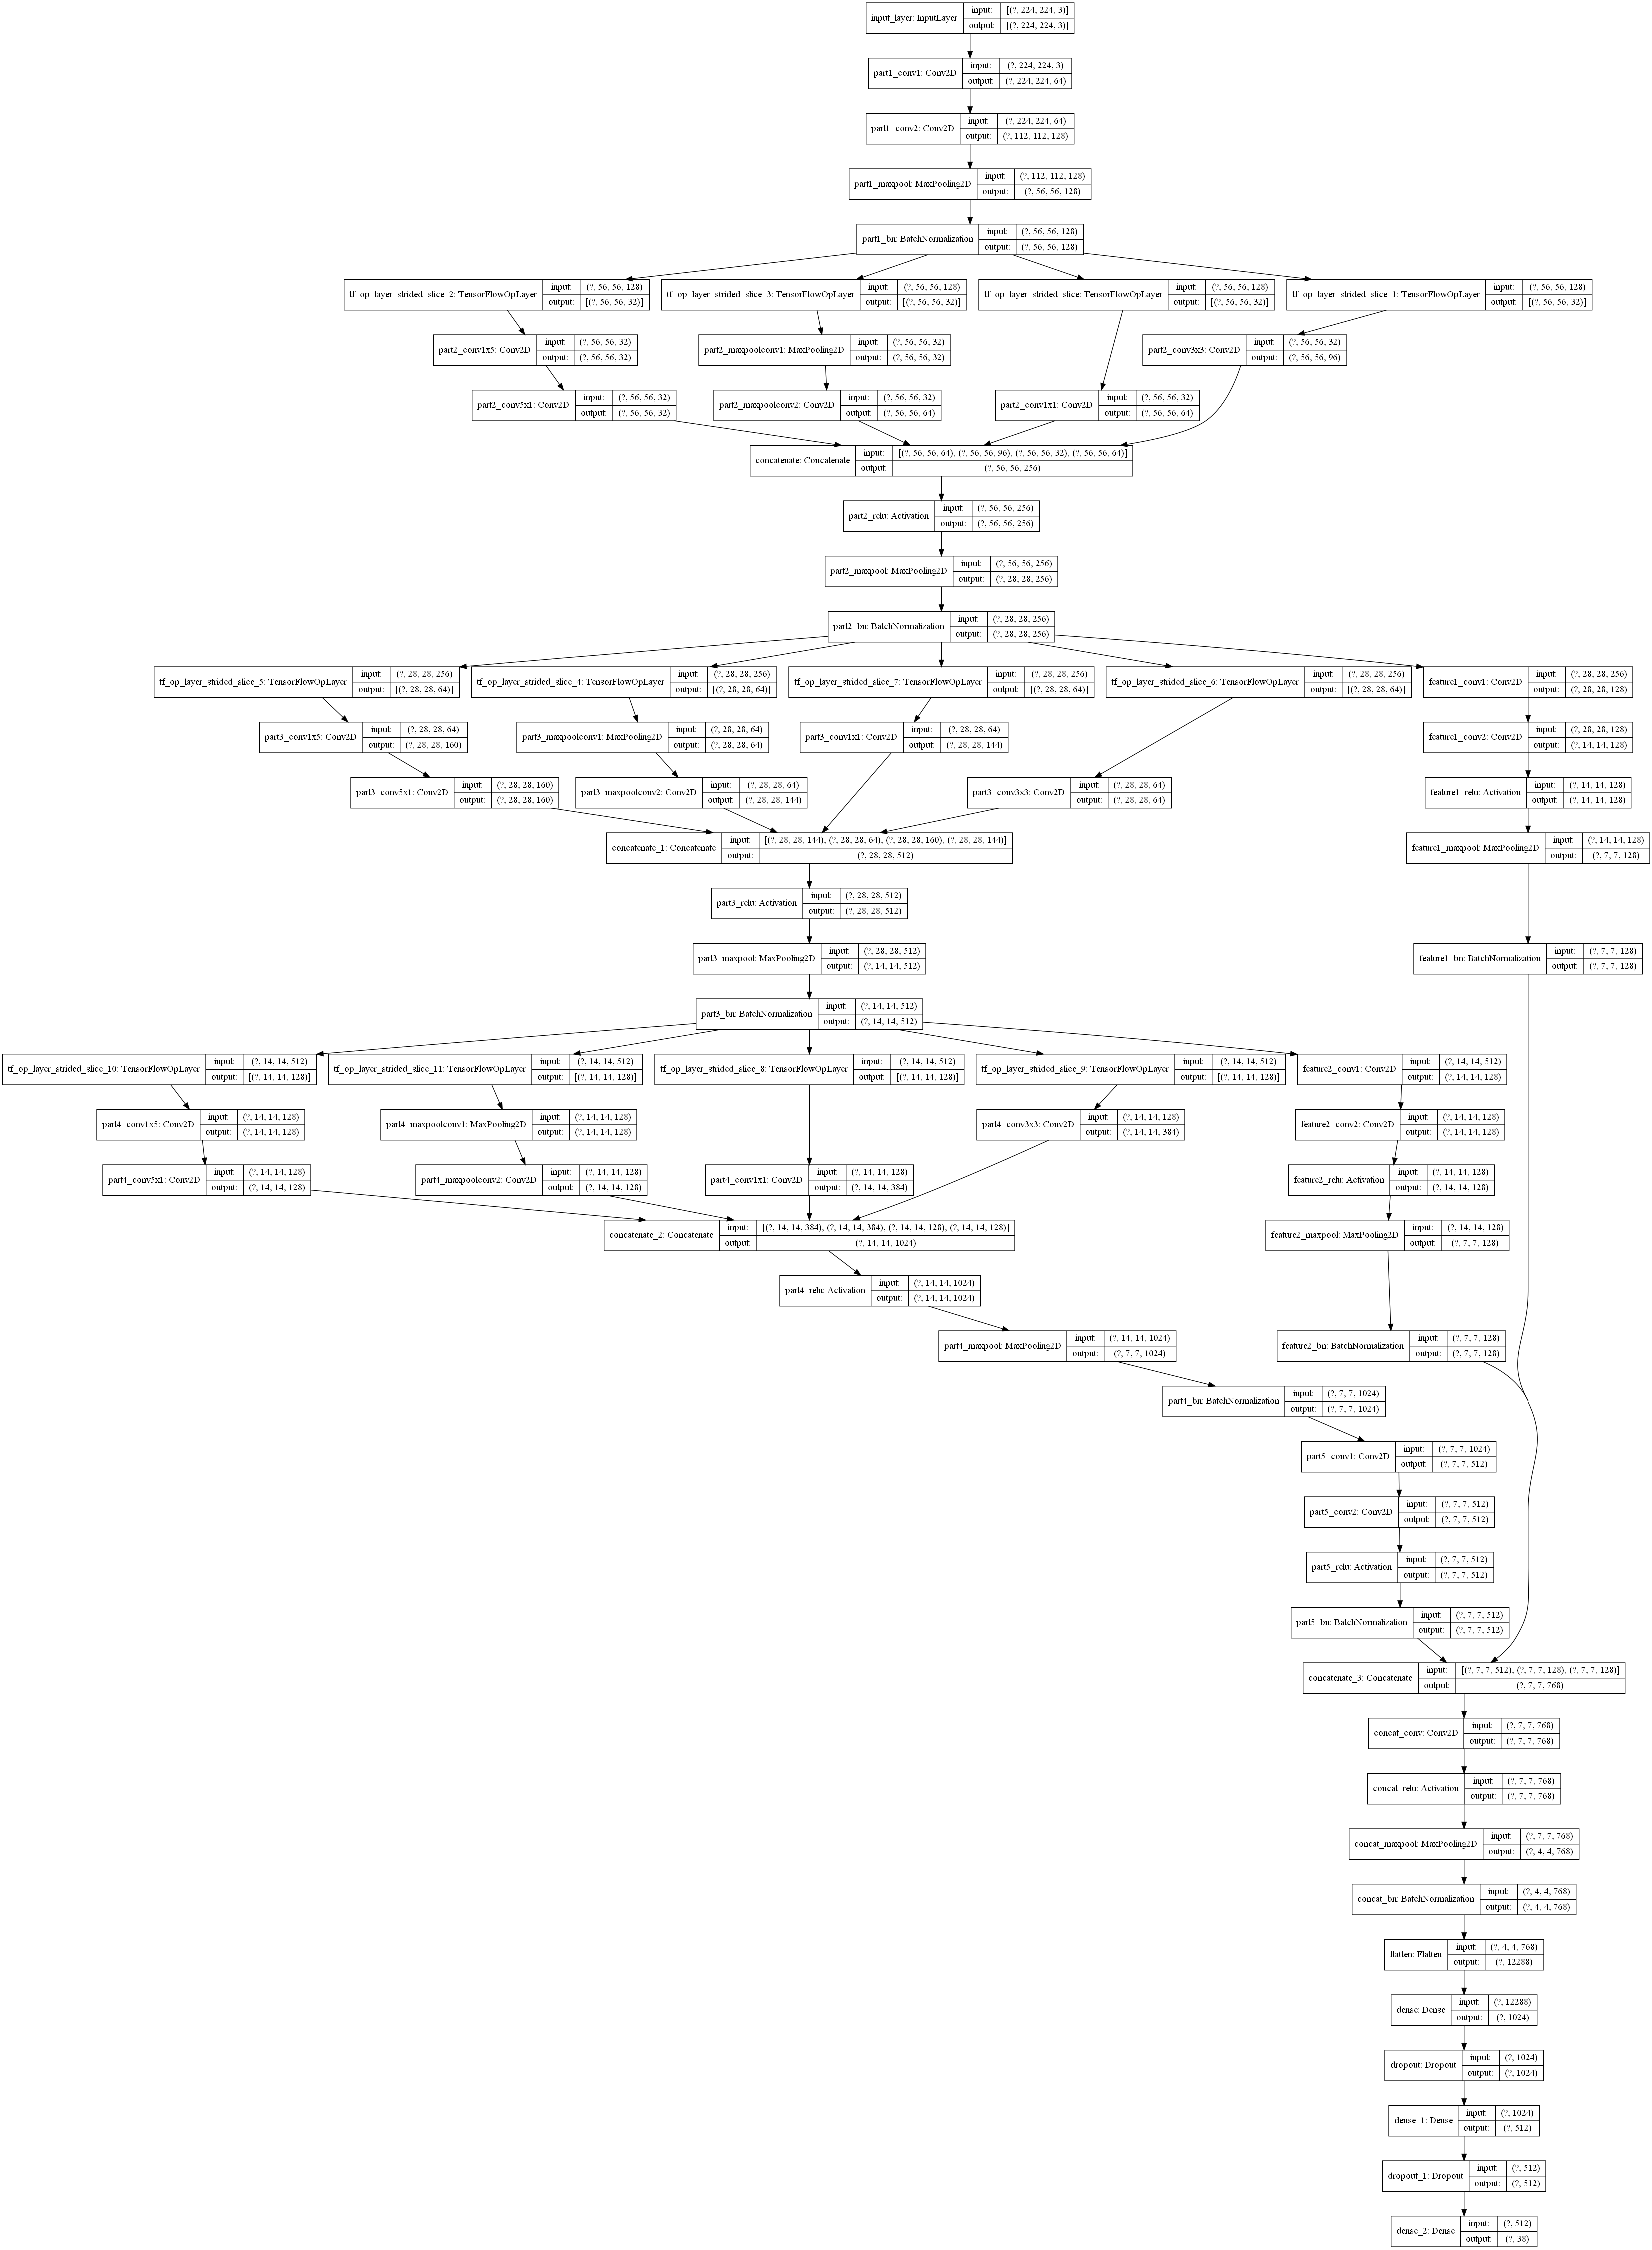

In [8]:
plot_model(model, to_file="./ChannelSplitNet-DenseOutput.png", show_shapes=True)

#### 3.1.2.1 First training

In [13]:
current_time = int(time.time())
print("current time: ", current_time)

tensorboard_dir_name = "MyNet_Dense-{}".format(current_time)
model_ckpt_dir = "Checkpoint/MyNet/MyNet_Dense-{}".format(current_time)
if not os.path.exists(model_ckpt_dir):
    os.mkdir(model_ckpt_dir)

my_callbacks = [EarlyStopping(monitor="val_accuracy", mode="max", patience=5, verbose=1), ModelCheckpoint(filepath=os.path.join(model_ckpt_dir, "MyNet_Dense-{epoch:02d}-{val_accuracy:.2f}.ckpt"), save_weights_only=True, save_freq="epoch", verbose=1), TensorBoard(log_dir="Logs/{}".format(tensorboard_dir_name), histogram_freq=1, update_freq="epoch")]

current time:  1618087375


In [14]:
lr_decay = PiecewiseConstantDecay([2613*2, 2613*4, 2613*6], [0.001, 0.0001, 0.00001, 0.000001])

model.compile(loss=categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=lr_decay), metrics=['accuracy'])

In [15]:
history = model.fit(x=train_x, y=label_y, epochs=50, batch_size=16, validation_data=(valid_x, valid_label_y), validation_batch_size=16, callbacks=my_callbacks)

Epoch 1/50
   1/5225 [..............................] - ETA: 0s - loss: 4.8437 - accuracy: 0.0625WARNING:tensorflow:From D:\Miniconda\Install\envs\FinalProject\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
5225/5225 [==============================] - ETA: 0s - loss: 1.8802 - accuracy: 0.4717
Epoch 00001: saving model to Checkpoint/MyNet/MyNet_Dense-1618087375\MyNet_Dense-01-0.59.ckpt
5225/5225 [==============================] - 1837s 352ms/step - loss: 1.8802 - accuracy: 0.4717 - val_loss: 1.4201 - val_accuracy: 0.5942
Epoch 2/50
5225/5225 [==============================] - ETA: 0s - loss: 0.6058 - accuracy: 0.8138
Epoch 00002: saving model to Checkpoint/MyNet/MyNet_Dense-1618087375\MyNet_Dense-02-0.89.ckpt
5225/5225 [==============================] - 1834s 351ms/step - loss: 0.6058 - accuracy: 0.8138 

KeyboardInterrupt: 

#### 3.1.2.2 Second training

In [27]:
model.load_weights("Checkpoint/MyNet/MyNet_Dense-1618087375\MyNet_Dense-03-0.92.ckpt")

In [24]:
current_time = int(time.time())
print("current time: ", current_time)

tensorboard_dir_name = "MyNet_Dense-{}".format(current_time)
model_ckpt_dir = "Checkpoint/MyNet/MyNet_Dense-{}".format(current_time)
if not os.path.exists(model_ckpt_dir):
    os.mkdir(model_ckpt_dir)

my_callbacks = [EarlyStopping(monitor="val_accuracy", mode="max", patience=5, verbose=1), ModelCheckpoint(filepath=os.path.join(model_ckpt_dir, "MyNet_Dense-{epoch:02d}-{val_accuracy:.2f}.ckpt"), save_weights_only=True, save_freq="epoch", verbose=1), TensorBoard(log_dir="Logs/{}".format(tensorboard_dir_name), histogram_freq=1, update_freq="epoch")]

current time:  1618154905


In [28]:
lr_decay = PiecewiseConstantDecay([2613*1, 2613*3], [0.0001, 0.00001, 0.000001])

model.compile(loss=categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=lr_decay), metrics=['accuracy'])

In [29]:
history = model.fit(x=train_x, y=label_y, epochs=50, batch_size=16, validation_data=(valid_x, valid_label_y), validation_batch_size=16, callbacks=my_callbacks)

Epoch 1/50
5225/5225 [==============================] - ETA: 0s - loss: 0.3905 - accuracy: 0.8783
Epoch 00001: saving model to Checkpoint/MyNet/MyNet_Dense-1618154905\MyNet_Dense-01-0.93.ckpt
5225/5225 [==============================] - 1834s 351ms/step - loss: 0.3905 - accuracy: 0.8783 - val_loss: 0.2289 - val_accuracy: 0.9310
Epoch 2/50
5225/5225 [==============================] - ETA: 0s - loss: 0.3287 - accuracy: 0.8963
Epoch 00002: saving model to Checkpoint/MyNet/MyNet_Dense-1618154905\MyNet_Dense-02-0.93.ckpt
5225/5225 [==============================] - 1832s 351ms/step - loss: 0.3287 - accuracy: 0.8963 - val_loss: 0.2197 - val_accuracy: 0.9332
Epoch 3/50
5225/5225 [==============================] - ETA: 0s - loss: 0.3245 - accuracy: 0.8979
Epoch 00003: saving model to Checkpoint/MyNet/MyNet_Dense-1618154905\MyNet_Dense-03-0.93.ckpt
5225/5225 [==============================] - 1834s 351ms/step - loss: 0.3245 - accuracy: 0.8979 - val_loss: 0.2181 - val_accuracy: 0.9332
Epoch 4/50

KeyboardInterrupt: 

#### 3.1.2.3 Third training

In [13]:
model.load_weights("Checkpoint\MyNet\MyNet_Dense-1618154905\MyNet_Dense-18-0.94.ckpt")

In [14]:
current_time = int(time.time())
print("current time: ", current_time)

tensorboard_dir_name = "MyNet_Dense-{}".format(current_time)
model_ckpt_dir = "Checkpoint/MyNet/MyNet_Dense-{}".format(current_time)
if not os.path.exists(model_ckpt_dir):
    os.mkdir(model_ckpt_dir)

my_callbacks = [EarlyStopping(monitor="val_accuracy", mode="max", patience=5, verbose=1), ModelCheckpoint(filepath=os.path.join(model_ckpt_dir, "MyNet_Dense-{epoch:02d}-{val_accuracy:.2f}.ckpt"), save_weights_only=True, save_freq="epoch", verbose=1), TensorBoard(log_dir="Logs/{}".format(tensorboard_dir_name), histogram_freq=1, update_freq="epoch")]

current time:  1618234263


In [22]:
model.compile(loss=categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001), metrics=['accuracy'])

In [16]:
history = model.fit(x=train_x, y=label_y, epochs=50, batch_size=16, validation_data=(valid_x, valid_label_y), validation_batch_size=16, callbacks=my_callbacks)

Epoch 1/50
   1/5225 [..............................] - ETA: 0s - loss: 0.2418 - accuracy: 0.9375WARNING:tensorflow:From D:\Miniconda\Install\envs\FinalProject\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
5225/5225 [==============================] - ETA: 0s - loss: 0.2970 - accuracy: 0.9058
Epoch 00001: saving model to Checkpoint/MyNet/MyNet_Dense-1618234263\MyNet_Dense-01-0.94.ckpt
5225/5225 [==============================] - 1837s 352ms/step - loss: 0.2970 - accuracy: 0.9058 - val_loss: 0.2029 - val_accuracy: 0.9380
Epoch 2/50
5225/5225 [==============================] - ETA: 0s - loss: 0.2918 - accuracy: 0.9071
Epoch 00002: saving model to Checkpoint/MyNet/MyNet_Dense-1618234263\MyNet_Dense-02-0.94.ckpt
5225/5225 [==============================] - 1839s 352ms/step - loss: 0.2918 - accuracy: 0.9071 

KeyboardInterrupt: 

#### 3.1.2.4 Fourth training

In [20]:
model.load_weights("F:\zxw780\Checkpoint\MyNet\MyNet_Dense-1618234263\MyNet_Dense-15-0.94.ckpt")

In [17]:
current_time = int(time.time())
print("current time: ", current_time)

tensorboard_dir_name = "MyNet_Dense-{}".format(current_time)
model_ckpt_dir = "Checkpoint/MyNet/MyNet_Dense-{}".format(current_time)
if not os.path.exists(model_ckpt_dir):
    os.mkdir(model_ckpt_dir)

my_callbacks = [EarlyStopping(monitor="val_accuracy", mode="max", patience=5, verbose=1), ModelCheckpoint(filepath=os.path.join(model_ckpt_dir, "MyNet_Dense-{epoch:02d}-{val_accuracy:.2f}.ckpt"), save_weights_only=True, save_freq="epoch", verbose=1), TensorBoard(log_dir="Logs/{}".format(tensorboard_dir_name), histogram_freq=1, update_freq="epoch")]

current time:  1618263091


In [18]:
lr_decay = PiecewiseConstantDecay([2613*2], [0.00001, 0.000001])

model.compile(loss=categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=lr_decay), metrics=['accuracy'])

In [21]:
history = model.fit(x=train_x, y=label_y, epochs=50, batch_size=16, validation_data=(valid_x, valid_label_y), validation_batch_size=16, callbacks=my_callbacks)

Epoch 1/50
5225/5225 [==============================] - ETA: 0s - loss: 0.2678 - accuracy: 0.9144
Epoch 00001: saving model to Checkpoint/MyNet/MyNet_Dense-1618263091\MyNet_Dense-01-0.94.ckpt
5225/5225 [==============================] - 1838s 352ms/step - loss: 0.2678 - accuracy: 0.9144 - val_loss: 0.1935 - val_accuracy: 0.9411
Epoch 2/50
5225/5225 [==============================] - ETA: 0s - loss: 0.2736 - accuracy: 0.9133
Epoch 00002: saving model to Checkpoint/MyNet/MyNet_Dense-1618263091\MyNet_Dense-02-0.94.ckpt
5225/5225 [==============================] - 1832s 351ms/step - loss: 0.2736 - accuracy: 0.9133 - val_loss: 0.1909 - val_accuracy: 0.9418
Epoch 3/50
5225/5225 [==============================] - ETA: 0s - loss: 0.2683 - accuracy: 0.9154
Epoch 00003: saving model to Checkpoint/MyNet/MyNet_Dense-1618263091\MyNet_Dense-03-0.94.ckpt
5225/5225 [==============================] - 1831s 350ms/step - loss: 0.2683 - accuracy: 0.9154 - val_loss: 0.1905 - val_accuracy: 0.9422
Epoch 4/50

KeyboardInterrupt: 

#### 3.1.2.5 Save the best model

Save the best model for evaluation. The best model is the epoch 3 of the fourth training. No early stop on this training. It is stopped manually, as it did not have a significant improve after 20 epochs.

In [21]:
model.load_weights(filepath="Checkpoint\MyNet\MyNet_Dense-1618263091\MyNet_Dense-03-0.94.ckpt")

In [23]:
model.save(filepath="BestModel/ChannelSplitNet_Dense_Model.h5")

### 3.1.3 Conv-Flatten output training

This is the training percudure for ChannelSplitNet Conv-Flatten output.

In [25]:
input_layer, x = channelSplitNet(denseLayer=False)
model = Model(input_layer, x)

In [26]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
part1_conv1 (Conv2D)            (None, 224, 224, 64) 4864        input_layer[0][0]                
__________________________________________________________________________________________________
part1_conv2 (Conv2D)            (None, 112, 112, 128 204928      part1_conv1[0][0]                
__________________________________________________________________________________________________
part1_maxpool (MaxPooling2D)    (None, 56, 56, 128)  0           part1_conv2[0][0]                
_______________________________________________________________________________________

#### 3.1.3.1 Conv-Flatten output first training

In [15]:
current_time = int(time.time())
print("current time: ", current_time)

tensorboard_dir_name = "MyNet_Conv-{}".format(current_time)
model_ckpt_dir = "Checkpoint/MyNet/MyNet_Conv-{}".format(current_time)
if not os.path.exists(model_ckpt_dir):
    os.mkdir(model_ckpt_dir)

my_callbacks = [EarlyStopping(monitor="val_accuracy", mode="max", patience=5, verbose=1), ModelCheckpoint(filepath=os.path.join(model_ckpt_dir, "MyNet-{epoch:02d}-{val_accuracy:.2f}.ckpt"), save_weights_only=True, save_freq="epoch", verbose=1), TensorBoard(log_dir="Logs/{}".format(tensorboard_dir_name), histogram_freq=1, update_freq="epoch")]

current time:  1618315889


In [17]:
lr_decay = PiecewiseConstantDecay([2613*3, 2613*6, 2613*9], [0.001, 0.0001, 0.00001, 0.000001])

model.compile(loss=categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=lr_decay), metrics=['accuracy'])

In [18]:
history = model.fit(x=train_x, y=label_y, epochs=50, batch_size=32, validation_data=(valid_x, valid_label_y), validation_batch_size=32, callbacks=my_callbacks)

Epoch 1/50
   1/2613 [..............................] - ETA: 0s - loss: 4.6665 - accuracy: 0.0000e+00WARNING:tensorflow:From D:\Miniconda\Install\envs\FinalProject\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
2613/2613 [==============================] - ETA: 0s - loss: 1.5556 - accuracy: 0.7036
Epoch 00001: saving model to Checkpoint/MyNet/MyNet_Conv-1618315889\MyNet-01-0.32.ckpt
2613/2613 [==============================] - 1584s 606ms/step - loss: 1.5556 - accuracy: 0.7036 - val_loss: 5.4020 - val_accuracy: 0.3219
Epoch 2/50
2613/2613 [==============================] - ETA: 0s - loss: 0.3993 - accuracy: 0.8845
Epoch 00002: saving model to Checkpoint/MyNet/MyNet_Conv-1618315889\MyNet-02-0.85.ckpt
2613/2613 [==============================] - 1578s 604ms/step - loss: 0.3993 - accuracy: 0.8845 - val_loss

#### 3.1.3.2 Conv-Flatten output second training

In [13]:
model.load_weights("Checkpoint\MyNet\MyNet_Conv-1618315889\MyNet-13-0.97.ckpt")

In [12]:
current_time = int(time.time())
print("current time: ", current_time)

tensorboard_dir_name = "MyNet_Conv-{}".format(current_time)
model_ckpt_dir = "Checkpoint/MyNet/MyNet_Conv-{}".format(current_time)
if not os.path.exists(model_ckpt_dir):
    os.mkdir(model_ckpt_dir)

my_callbacks = [EarlyStopping(monitor="val_accuracy", mode="max", patience=5, verbose=1), ModelCheckpoint(filepath=os.path.join(model_ckpt_dir, "MyNet-{epoch:02d}-{val_accuracy:.2f}.ckpt"), save_weights_only=True, save_freq="epoch", verbose=1), TensorBoard(log_dir="Logs/{}".format(tensorboard_dir_name), histogram_freq=1, update_freq="epoch")]

current time:  1618344225


In [28]:
model.compile(loss=categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001), metrics=['accuracy'])

In [15]:
history = model.fit(x=train_x, y=label_y, epochs=50, batch_size=32, validation_data=(valid_x, valid_label_y), validation_batch_size=32, callbacks=my_callbacks)

Epoch 1/50
   1/2613 [..............................] - ETA: 0s - loss: 0.0348 - accuracy: 0.9688WARNING:tensorflow:From D:\Miniconda\Install\envs\FinalProject\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
2613/2613 [==============================] - ETA: 0s - loss: 0.0184 - accuracy: 0.9953
Epoch 00001: saving model to Checkpoint/MyNet/MyNet_Conv-1618344225\MyNet-01-0.97.ckpt
2613/2613 [==============================] - 1582s 605ms/step - loss: 0.0184 - accuracy: 0.9953 - val_loss: 3.2649 - val_accuracy: 0.9743
Epoch 2/50
2613/2613 [==============================] - ETA: 0s - loss: 0.0187 - accuracy: 0.9949
Epoch 00002: saving model to Checkpoint/MyNet/MyNet_Conv-1618344225\MyNet-02-0.97.ckpt
2613/2613 [==============================] - 1580s 605ms/step - loss: 0.0187 - accuracy: 0.9949 - val_loss: 1.

#### 3.1.3.3 Save the best model

Save the best model for evaluation. The best model is epoch 6 of second training. Early stop performed on this training.

In [27]:
model.load_weights("Checkpoint\MyNet\MyNet_Conv-1618344225\MyNet-06-0.98.ckpt")

In [29]:
model.save(filepath="BestModel/ChannelSplitNet_CF_Model.h5")

## 3.2 GoogLeNet

### 3.2.1 Build the network

In [15]:
def inception_part(x, filters_num):
    '''
    :param x: feature map for inception part
    :param filters_num: The number of filters to perform convolution operation on x
    :return: The output of inception part
    '''
    conv_1x1 = Conv2D(filters=filters_num[0], kernel_size=(1,1), strides=1, padding='same')(x)

    conv_3x3 = Conv2D(filters=filters_num[1], kernel_size=(1,1), strides=1, padding='same')(x)
    conv_3x3 = Conv2D(filters=filters_num[2], kernel_size=(3,3), strides=1, padding='same')(conv_3x3)

    conv_5x5 = Conv2D(filters=filters_num[3], kernel_size=(1,1), strides=1, padding='same')(x)
    conv_5x5 = Conv2D(filters=filters_num[4], kernel_size=(5,5), strides=1, padding='same')(conv_5x5)

    maxPool_Conv = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(x)
    maxPool_Conv = Conv2D(filters=filters_num[5], kernel_size=(1,1), strides=1, padding='same')(maxPool_Conv)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, maxPool_Conv])

    return output

In [16]:
input_layer = Input(shape=(224,224,3))

# convolution & max pool
x = Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same')(input_layer)
x = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(x)
x = BatchNormalization(trainable=False)(x)

# convolution
x = Conv2D(filters=64, kernel_size=(1,1), strides=1, padding='same')(x)
x = Conv2D(filters=192, kernel_size=(3,3), strides=1, padding='same')(x)
x = BatchNormalization(trainable=False)(x)

# max pool
x = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(x)

#inception 3a
x = inception_part(x, [64, 96, 128, 16, 32, 32])

# inception 3b
x = inception_part(x, [128, 128, 192, 32, 96, 64])

# max pool
x = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(x)

# inception 4a
x = inception_part(x, [192, 96, 208, 16, 48, 64])

# softmax0
x0 = AveragePooling2D(pool_size=(5,5), strides=3, padding='valid')(x)
x0 = Conv2D(filters=128, kernel_size=(1,1), strides=1, activation='relu')(x0)
x0 = Flatten()(x0)
x0 = Dense(units=1024, activation='relu')(x0)
x0 = Dropout(0.7)(x0)
x0 = Dense(units=38, activation='softmax', name='softmax0')(x0)

# inception 4b
x = inception_part(x, [160, 112, 224, 24, 64, 64])

# inception 4c
x = inception_part(x, [128, 128, 256, 24, 64, 64])

# inception 4d
x = inception_part(x, [112, 144, 288, 32, 64, 64])

# softmax1
x1 = AveragePooling2D(pool_size=(5,5), strides=3, padding='valid')(x)
x1 = Conv2D(filters=128, kernel_size=(1,1), strides=1, activation='relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(units=1024, activation='relu')(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(units=38, activation='softmax', name='softmax1')(x1)

# inception 4e
x = inception_part(x, [256, 160, 320, 32, 128, 128])

# maxpool
x = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(x)

#inception 5a
x = inception_part(x, [256, 160, 320, 32, 128, 128])

# inception 5b
x = inception_part(x, [384, 192, 384, 48, 128, 128])

# output/softmax2
x = AveragePooling2D(pool_size=(7,7), strides=1, padding='valid')(x)
x = Flatten()(x)
x = Dropout(0.4)(x)
x = Dense(units=512, activation='relu')(x)
x = Dense(units=38, activation='softmax', name='output')(x)

In [17]:
model = Model(input_layer, [x0, x1, x])

In [18]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 56, 56, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 56, 56, 64)   256         max_pooling2d[0][0]              
_______________________________________________________________________________________

### 3.2.2 GoogLeNet Training

This is the training percudure for GoogLeNet

In [12]:
current_time = int(time.time())
print("current time: ", current_time)

tensorboard_dir_name = "GoogLeNet-{}".format(current_time)
model_ckpt_dir = "Checkpoint/GoogLeNet/GoogLeNet-{}".format(current_time)
if not os.path.exists(model_ckpt_dir):
    os.mkdir(model_ckpt_dir)

my_callbacks = [EarlyStopping(monitor="val_output_accuracy", mode="max", patience=5, verbose=1), ModelCheckpoint(filepath=os.path.join(model_ckpt_dir, "GoogLeNet-{epoch:02d}-{val_output_accuracy:.2f}.ckpt"), save_weights_only=True, save_freq="epoch", verbose=1), TensorBoard(log_dir="Logs/{}".format(tensorboard_dir_name), histogram_freq=1, update_freq="epoch")]

current time:  1614284894


In [13]:
lr_decay = PiecewiseConstantDecay([2613*5,2613*8], [0.0001, 0.00001, 0.000001])

model.compile(loss=categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=lr_decay), metrics=['accuracy'])

In [14]:
history = model.fit(x=train_x, y=label_y, epochs=50, batch_size=32, validation_data=(valid_x, valid_label_y), validation_batch_size=32, callbacks=my_callbacks)

Epoch 1/50
   1/2613 [..............................] - ETA: 0s - loss: 683.2452 - softmax0_loss: 210.5362 - softmax1_loss: 231.6963 - output_loss: 241.0128 - softmax0_accuracy: 0.0000e+00 - softmax1_accuracy: 0.0000e+00 - output_accuracy: 0.0312WARNING:tensorflow:From D:\Miniconda\Install\envs\FinalProject\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
2613/2613 [==============================] - ETA: 0s - loss: 7.9047 - softmax0_loss: 2.4342 - softmax1_loss: 2.5456 - output_loss: 2.9249 - softmax0_accuracy: 0.4034 - softmax1_accuracy: 0.3843 - output_accuracy: 0.4358
Epoch 00001: saving model to Checkpoint/GoogLeNet/GoogLeNet-1614284894\GoogLeNet-01-0.73.ckpt
2613/2613 [==============================] - 755s 289ms/step - loss: 7.9047 - softmax0_loss: 2.4342 - softmax1_loss: 2.5456 - output_loss: 2.924

### 3.2.3 Save the best model

Save the best model for evaluation. The best model is epoch 18. Early stop performs on this training.

In [19]:
model.load_weights(filepath="Checkpoint\GoogLeNet\GoogLeNet-1614284894\GoogLeNet-18-0.98.ckpt")

In [21]:
model.save("BestModel/GoogLeNet_Model.h5")

## 3.3 AlexNet

### 3.3.1 Build the network

In [35]:
def AlexNet(denseOutput = True):
    '''
    :param denseOutput: Set whether the network uses dense output or Conv-Flatten output. Default is True.
    :return: AlexNet
    '''

    model = Sequential()

    # 1st Convolutional Layer
    model.add(Conv2D(input_shape=(227,227,3), filters=96, kernel_size=(11,11), strides=(4,4), padding="valid"))
    model.add(Activation(activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding="valid"))

    # 2nd Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(5,5), strides=1, padding="same"))
    model.add(Activation(activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding="valid"))

    # 3rd Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=1, padding="same"))
    model.add(Activation(activation="relu"))
    model.add(BatchNormalization())

    # 4th Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=1, padding="same"))
    model.add(Activation(activation="relu"))
    model.add(BatchNormalization())

    # 5th Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=1, padding="same"))
    model.add(Activation(activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding="valid"))

    # Use either dense output or Conv-Flatten output
    if denseOutput:
        model.add(Flatten())
        model.add(Dense(4096, activation="relu"))
        model.add(Dropout(0.5))
        model.add(Dense(4096, activation="relu"))
        model.add(Dropout(0.5))
        model.add(Dense(38, activation="softmax"))
    else:
        model.add(Conv2D(filters=38, kernel_size=(6,6), padding='valid'))
        model.add(Flatten())
        model.add(Activation('softmax'))

    return model

### 3.3.2 AlexNet dense output training

This is the training percudure for AlexNet dense output

In [36]:
model = AlexNet(denseOutput=True)
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 55, 55, 96)        34944     
_________________________________________________________________
activation_8 (Activation)    (None, 55, 55, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
activation_9 (Activation)    (None, 27, 27, 256)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 256)      

In [10]:
current_time = int(time.time())
print("current time: ", current_time)

tensorboard_dir_name = "AlexNet-{}".format(current_time)
model_ckpt_dir = "Checkpoint/AlexNet/AlexNet-{}".format(current_time)
if not os.path.exists(model_ckpt_dir):
    os.mkdir(model_ckpt_dir)

my_callbacks = [EarlyStopping(monitor="val_accuracy", mode="max", patience=5, verbose=1), ModelCheckpoint(filepath=os.path.join(model_ckpt_dir, "AlexNet-{epoch:02d}-{val_accuracy:.2f}.ckpt"), save_weights_only=True, save_freq="epoch", verbose=1), TensorBoard(log_dir="logs/{}".format(tensorboard_dir_name), histogram_freq=1, update_freq="epoch")]

current time:  1614348416


In [11]:
lr_decay = PiecewiseConstantDecay([2613*5,2613*8], [0.0001, 0.00001, 0.000001])

model.compile(loss=categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=lr_decay), metrics=['accuracy'])

In [12]:
history = model.fit(x=train_x, y=label_y, epochs=50, batch_size=32, validation_data=(valid_x, valid_label_y), validation_batch_size=32, callbacks=my_callbacks)

Epoch 1/50
   1/2613 [..............................] - ETA: 2s - loss: 6.8781 - accuracy: 0.0000e+00WARNING:tensorflow:From D:\Miniconda\Install\envs\FinalProject\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
2613/2613 [==============================] - ETA: 0s - loss: 1.4331 - accuracy: 0.5996
Epoch 00001: saving model to Checkpoint/AlexNet/AlexNet-1614348416\AlexNet-01-0.46.ckpt
2613/2613 [==============================] - 316s 121ms/step - loss: 1.4331 - accuracy: 0.5996 - val_loss: 2.7285 - val_accuracy: 0.4598
Epoch 2/50
2613/2613 [==============================] - ETA: 0s - loss: 0.5758 - accuracy: 0.8237
Epoch 00002: saving model to Checkpoint/AlexNet/AlexNet-1614348416\AlexNet-02-0.64.ckpt
2613/2613 [==============================] - 299s 114ms/step - loss: 0.5758 - accuracy: 0.8237 - val_loss

#### 3.3.2.1 Save the best model

Save the best model for evaluaion. The best model is epoch 9. Early stop performs on this training.

In [32]:
model.load_weights(filepath="Checkpoint\AlexNet\AlexNet-1614348416/AlexNet-09-0.98.ckpt")

In [34]:
model.save(filepath="BestModel/AlexNet_Dense_Model.h5")

### 3.3.3 AlexNet Conv-Flatten output training

This is the training percudure for AlexNet Conv-Flatten output

In [37]:
model = AlexNet(denseOutput=False)

In [38]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 55, 55, 96)        34944     
_________________________________________________________________
activation_13 (Activation)   (None, 55, 55, 96)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 27, 27, 256)       614656    
_________________________________________________________________
activation_14 (Activation)   (None, 27, 27, 256)       0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 27, 27, 256)      

In [17]:
current_time = int(time.time())
print("current time: ", current_time)

tensorboard_dir_name = "AlexNet_CF-{}".format(current_time)
model_ckpt_dir = "Checkpoint/AlexNet/AlexNet_CF-{}".format(current_time)
if not os.path.exists(model_ckpt_dir):
    os.mkdir(model_ckpt_dir)

my_callbacks = [EarlyStopping(monitor="val_accuracy", mode="max", patience=3, verbose=1), ModelCheckpoint(filepath=os.path.join(model_ckpt_dir, "AlexNet_CF-{epoch:02d}-{val_accuracy:.2f}.ckpt"), save_weights_only=True, save_freq="epoch", verbose=1), TensorBoard(log_dir="logs/{}".format(tensorboard_dir_name), histogram_freq=1, update_freq="epoch")]

current time:  1618065751


In [18]:
lr_decay = PiecewiseConstantDecay([2613*2,2613*4], [0.0001, 0.00001, 0.000001])

model.compile(loss=categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=lr_decay), metrics=['accuracy'])

In [19]:
history = model.fit(x=train_x, y=label_y, epochs=50, batch_size=32, validation_data=(valid_x, valid_label_y), validation_batch_size=32, callbacks=my_callbacks)

Epoch 1/50
2613/2613 [==============================] - ETA: 0s - loss: 0.9968 - accuracy: 0.7064
Epoch 00001: saving model to Checkpoint/AlexNet/AlexNet_CF-1618065751\AlexNet_CF-01-0.36.ckpt
2613/2613 [==============================] - 221s 85ms/step - loss: 0.9968 - accuracy: 0.7064 - val_loss: 3.6184 - val_accuracy: 0.3648
Epoch 2/50
2612/2613 [============================>.] - ETA: 0s - loss: 0.3818 - accuracy: 0.8778
Epoch 00002: saving model to Checkpoint/AlexNet/AlexNet_CF-1618065751\AlexNet_CF-02-0.42.ckpt
2613/2613 [==============================] - 218s 83ms/step - loss: 0.3818 - accuracy: 0.8778 - val_loss: 3.5513 - val_accuracy: 0.4219
Epoch 3/50
2612/2613 [============================>.] - ETA: 0s - loss: 0.1225 - accuracy: 0.9602
Epoch 00003: saving model to Checkpoint/AlexNet/AlexNet_CF-1618065751\AlexNet_CF-03-0.94.ckpt
2613/2613 [==============================] - 220s 84ms/step - loss: 0.1225 - accuracy: 0.9602 - val_loss: 0.1848 - val_accuracy: 0.9396
Epoch 4/50
2612/

#### 3.3.3.1 Save the best model

Save the best model for evaluation. The best model is epoch 19. Early stop performs on this training

In [39]:
model.load_weights("Checkpoint/AlexNet/AlexNet_CF-1618065751\AlexNet_CF-19-0.96.ckpt")

In [40]:
model.save("BestModel/AlexNet_CF_Model.h5")

## 3.4 VGG16

### 3.4.1 Build the network

In [14]:
model = Sequential()

# Part 1
model.add(Conv2D(input_shape=(224,224,3), filters=64, kernel_size=(3,3), strides=(1,1), padding="same"))
model.add(BatchNormalization())
model.add(Activation(activation="relu"))
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding="same"))
model.add(BatchNormalization())
model.add(Activation(activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# Part 2
model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding="same"))
model.add(BatchNormalization())
model.add(Activation(activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding="same"))
model.add(BatchNormalization())
model.add(Activation(activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# Part 3
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding="same"))
model.add(BatchNormalization())
model.add(Activation(activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding="same"))
model.add(BatchNormalization())
model.add(Activation(activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding="same"))
model.add(BatchNormalization())
model.add(Activation(activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# Part 4
model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding="same"))
model.add(BatchNormalization())
model.add(Activation(activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding="same"))
model.add(BatchNormalization())
model.add(Activation(activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding="same"))
model.add(BatchNormalization())
model.add(Activation(activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# Part 5
model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding="same"))
model.add(BatchNormalization())
model.add(Activation(activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding="same"))
model.add(BatchNormalization())
model.add(Activation(activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding="same"))
model.add(BatchNormalization())
model.add(Activation(activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# Dense layer
model.add(Flatten())

model.add(Dense(units=4096, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=4096, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=38, activation="softmax"))

### 3.4.2 VGG16 trained from scratch

This is the VGG16 training procedure that trained from scratch

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 224, 224, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0

In [10]:
current_time = int(time.time())
print("current time: ", current_time)

tensorboard_dir_name = "VGG16-{}".format(current_time)
model_ckpt_dir = "Checkpoint/VGG16/VGG16-{}".format(current_time)
if not os.path.exists(model_ckpt_dir):
    os.mkdir(model_ckpt_dir)

my_callbacks = [EarlyStopping(monitor="val_accuracy", mode="max", patience=5, verbose=1), ModelCheckpoint(filepath=os.path.join(model_ckpt_dir, "VGG16-{epoch:02d}-{val_accuracy:.2f}.ckpt"), save_weights_only=True, save_freq="epoch", verbose=1), TensorBoard(log_dir="logs/{}".format(tensorboard_dir_name), histogram_freq=1, update_freq="epoch")]

current time:  1614774044


#### 3.4.2.1 First training

In [11]:
lr_decay = PiecewiseConstantDecay([11103*3,11103*5], [0.0001, 0.00001, 0.000001])

model.compile(loss=categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=lr_decay), metrics=['accuracy'])

In [12]:
history = model.fit(x=train_x, y=label_y, epochs=50, batch_size=8, validation_data=(valid_x, valid_label_y), validation_batch_size=8, callbacks=my_callbacks)

Epoch 1/50
    1/10450 [..............................] - ETA: 0s - loss: 5.1957 - accuracy: 0.0000e+00WARNING:tensorflow:From D:\Miniconda\Install\envs\FinalProject\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
10450/10450 [==============================] - ETA: 0s - loss: 1.7339 - accuracy: 0.4982
Epoch 00001: saving model to Checkpoint/VGG16/VGG16-1614427635\VGG16-01-0.68.ckpt
10450/10450 [==============================] - 4506s 431ms/step - loss: 1.7339 - accuracy: 0.4982 - val_loss: 0.9820 - val_accuracy: 0.6846
Epoch 2/50
10450/10450 [==============================] - ETA: 0s - loss: 0.6672 - accuracy: 0.7877
Epoch 00002: saving model to Checkpoint/VGG16/VGG16-1614427635\VGG16-02-0.78.ckpt
10450/10450 [==============================] - 4668s 447ms/step - loss: 0.6672 - accuracy: 0.7877 - val_loss

KeyboardInterrupt: 

In [13]:
model.save(filepath="ModelSaved/VGG16_224_epoch8.h5")

#### 3.4.2.2 Second training

In [9]:
model = load_model(filepath="ModelSaved/VGG16_224_epoch8.h5")

In [10]:
model.compile(loss=categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001), metrics=['accuracy'])

history = model.fit(x=train_x, y=label_y, epochs=50, batch_size=8, validation_data=(valid_x, valid_label_y), validation_batch_size=8, callbacks=my_callbacks)

Epoch 1/50
    1/10450 [..............................] - ETA: 0s - loss: 6.0586e-04 - accuracy: 1.0000WARNING:tensorflow:From D:\Miniconda\Install\envs\FinalProject\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
10450/10450 [==============================] - ETA: 0s - loss: 0.0697 - accuracy: 0.9770
Epoch 00001: saving model to Checkpoint/VGG16/VGG16-1614598613\VGG16-01-0.98.ckpt
10450/10450 [==============================] - 4521s 433ms/step - loss: 0.0697 - accuracy: 0.9770 - val_loss: 0.0648 - val_accuracy: 0.9797
Epoch 2/50
10450/10450 [==============================] - ETA: 0s - loss: 0.0663 - accuracy: 0.9775
Epoch 00002: saving model to Checkpoint/VGG16/VGG16-1614598613\VGG16-02-0.98.ckpt
10450/10450 [==============================] - 4528s 433ms/step - loss: 0.0663 - accuracy: 0.9775 - val_loss

KeyboardInterrupt: 

In [11]:
model.save(filepath="ModelSaved/VGG16_224_epoch10.h5")

#### 3.4.2.3 Third training

In [9]:
model = load_model(filepath="ModelSaved/VGG16_224_epoch10.h5")

In [12]:
model.compile(loss=categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001), metrics=['accuracy'])

history = model.fit(x=train_x, y=label_y, epochs=50, batch_size=8, validation_data=(valid_x, valid_label_y), validation_batch_size=8, callbacks=my_callbacks)

Epoch 1/50
    1/10450 [..............................] - ETA: 0s - loss: 0.4756 - accuracy: 0.8750WARNING:tensorflow:From D:\Miniconda\Install\envs\FinalProject\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
10450/10450 [==============================] - ETA: 0s - loss: 0.0557 - accuracy: 0.9814
Epoch 00001: saving model to Checkpoint/VGG16/VGG16-1614696188\VGG16-01-0.98.ckpt
10450/10450 [==============================] - 4530s 433ms/step - loss: 0.0557 - accuracy: 0.9814 - val_loss: 0.0616 - val_accuracy: 0.9807
Epoch 2/50
10450/10450 [==============================] - ETA: 0s - loss: 0.0544 - accuracy: 0.9815
Epoch 00002: saving model to Checkpoint/VGG16/VGG16-1614696188\VGG16-02-0.98.ckpt
10450/10450 [==============================] - 4537s 434ms/step - loss: 0.0544 - accuracy: 0.9815 - val_loss: 0.

KeyboardInterrupt: 

In [13]:
model.save(filepath="ModelSaved/VGG16_224_epoch7_3.h5")

#### 3.4.2.4 Fourth training

In [8]:
model = load_model(filepath="ModelSaved/VGG16_224_epoch7_3.h5")

In [11]:
model.compile(loss=categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001), metrics=['accuracy'])

history = model.fit(x=train_x, y=label_y, epochs=50, batch_size=8, validation_data=(valid_x, valid_label_y), validation_batch_size=8, callbacks=my_callbacks)

Epoch 1/50
    1/10450 [..............................] - ETA: 0s - loss: 1.0159e-04 - accuracy: 1.0000WARNING:tensorflow:From D:\Miniconda\Install\envs\FinalProject\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
10450/10450 [==============================] - ETA: 0s - loss: 0.0496 - accuracy: 0.9831
Epoch 00001: saving model to Checkpoint/VGG16/VGG16-1614774044\VGG16-01-0.98.ckpt
10450/10450 [==============================] - 4515s 432ms/step - loss: 0.0496 - accuracy: 0.9831 - val_loss: 0.0601 - val_accuracy: 0.9819
Epoch 2/50
10450/10450 [==============================] - ETA: 0s - loss: 0.0476 - accuracy: 0.9837
Epoch 00002: saving model to Checkpoint/VGG16/VGG16-1614774044\VGG16-02-0.98.ckpt
10450/10450 [==============================] - 4530s 433ms/step - loss: 0.0476 - accuracy: 0.9837 - val_loss

KeyboardInterrupt: 

In [12]:
model.save(filepath="ModelSaved/VGG16_224_epoch8_4.h5")

#### 3.4.2.5 Save the best model

Save the best model for evaluation. The best model is epoch 7 of fourth training. Training is stopped manually, as it did not have a significant improve after 20 epochs.

In [16]:
model.load_weights(filepath="Checkpoint\VGG16\VGG16-1614774044\VGG16-07-0.98.ckpt")

In [18]:
model.save(filepath="BestModel/VGG16_TfS_Model.h5")

### 3.4.3 Pretrained VGG16 with freezing Conv layer

This is the VGG16 with Conv part weights pretrained by ImageNet, and weights are frozen.

#### 3.4.3.1 Build the pretrained VGG16 network

In [8]:
def vgg_conv_layers(conv_layer_trainable=False, input_shape=(224,224,3)):
    '''
    :param conv_layer_trainable: Set VGG16 Conv parts trainable or not. Default is False.
    :param input_shape: Input shape to this network. Default is (224,224,3)
    :return: Pretrained VGG16 Conv part
    '''
    vgg_conv = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in vgg_conv.layers:
        layer.trainable=conv_layer_trainable

    for layer in vgg_conv.layers:
        print(layer, layer.trainable)

    return vgg_conv

In [3]:
def pretrained_VGG16(denseLayer=True, conv_layer_trainable=False):
    '''
    :param denseLayer: Network uses dense output or Conv-Flatten output. Denfault is True.
    :param conv_layer_trainable: Set VGG16 Conv parts trainable or not. Default is False.
    :return: Pretrained VGG16.
    '''
    model = Sequential()
    vgg_conv = vgg_conv_layers(conv_layer_trainable=False)
    model.add(vgg_conv)

    if denseLayer:
        model.add(Flatten())
        model.add(Dense(units=4096, activation="relu"))
        model.add(Dropout(0.3))
        model.add(Dense(units=4096, activation="relu"))
        model.add(Dropout(0.3))
        model.add(Dense(units=38, activation="softmax"))
    else:
        model.add(Conv2D(filters=38, kernel_size=(7,7), padding='valid'))
        model.add(Flatten())
        model.add(Activation('softmax'))

    return model

### 3.4.3.2 Pretrained VGG16 dense output training

This is the training procedure of pretrained VGG16 with dense output

In [29]:
model = pretrained_VGG16(denseLayer=True, conv_layer_trainable=False)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x0000020E337FF6C8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000020E3381FE88> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000020E3381FF48> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x0000020E337DE2C8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000020E337ACE08> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000020E3380B688> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x0000020E337B28C8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000020E33815DC8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000020E337F1148> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000020E337C1D08> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x0000020E337C30C8> False
<tensorflow.python.

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 4096)              102764544 
_________________________________________________________________
dropout_4 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_5 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 38)               

In [8]:
current_time = int(time.time())
print("current time: ", current_time)

tensorboard_dir_name = "Pretrained_VGG16-{}".format(current_time)
model_ckpt_dir = "Checkpoint/VGG16/Pretrained_VGG16-{}".format(current_time)
if not os.path.exists(model_ckpt_dir):
    os.mkdir(model_ckpt_dir)

my_callbacks = [EarlyStopping(monitor="val_accuracy", mode="max", patience=5, verbose=1), ModelCheckpoint(filepath=os.path.join(model_ckpt_dir, "Pretrained_VGG16-{epoch:02d}-{val_accuracy:.2f}.ckpt"), save_weights_only=True, save_freq="epoch", verbose=1), TensorBoard(log_dir="logs/{}".format(tensorboard_dir_name), histogram_freq=1, update_freq="epoch")]

current time:  1616433120


In [14]:
lr_decay = PiecewiseConstantDecay([2613*3,2613*5], [0.0001, 0.00001, 0.000001])

model.compile(loss=categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=lr_decay), metrics=['accuracy'])

In [15]:
history = model.fit(x=train_x, y=label_y, epochs=50, batch_size=32, validation_data=(valid_x, valid_label_y), validation_batch_size=32, callbacks=my_callbacks)

Epoch 1/50
   1/2613 [..............................] - ETA: 0s - loss: 20.3388 - accuracy: 0.0000e+00WARNING:tensorflow:From D:\Miniconda\Install\envs\FinalProject\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
2613/2613 [==============================] - ETA: 0s - loss: 1.4324 - accuracy: 0.7459
Epoch 00001: saving model to Checkpoint/VGG16/Pretrained_VGG16-1616433120\Pretrained_VGG16-01-0.87.ckpt
2613/2613 [==============================] - 967s 370ms/step - loss: 1.4324 - accuracy: 0.7459 - val_loss: 0.4383 - val_accuracy: 0.8733
Epoch 2/50
2613/2613 [==============================] - ETA: 0s - loss: 0.4213 - accuracy: 0.8871
Epoch 00002: saving model to Checkpoint/VGG16/Pretrained_VGG16-1616433120\Pretrained_VGG16-02-0.90.ckpt
2613/2613 [==============================] - 972s 372ms/step - loss: 0.4

KeyboardInterrupt: 

##### 3.4.3.2.1 Save the best model

Save the best model for evaluation. The best model is epoch 21. The training is stopped manually, as it did not have a significate improve after 20 epochs.

In [31]:
model.load_weights("Checkpoint\VGG16\Pretrained_VGG16-1616433120\Pretrained_VGG16-21-0.94.ckpt")

In [33]:
model.save(filepath="BestModel/VGG16_Pre_Dense_Model.h5")

### 

### 3.4.3.3 Pretrained VGG16 Conv-Flatten output training

This the training procedure of pretrained VGG16 with Conv-Flatten output.

In [34]:
model = pretrained_VGG16(denseLayer=False)
model.summary()

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x0000020E33896788> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000020E3389BC48> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000020E3389C188> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x0000020E338BBCC8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000020E338B8608> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000020E338B8D48> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x0000020E338C0C48> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000020E338C5448> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000020E338C5D88> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000020E338C9A88> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x0000020E338CE7C8> False
<tensorflow.python.

##### 3.4.3.3.1 First training

In [24]:
current_time = int(time.time())
print("current time: ", current_time)

tensorboard_dir_name = "Pretrained_VGG16_CF-{}".format(current_time)
model_ckpt_dir = "Checkpoint/VGG16/Pretrained_VGG16_CF-{}".format(current_time)
if not os.path.exists(model_ckpt_dir):
    os.mkdir(model_ckpt_dir)

my_callbacks = [EarlyStopping(monitor="val_accuracy", mode="max", patience=3, verbose=1), ModelCheckpoint(filepath=os.path.join(model_ckpt_dir, "Pretrained_VGG16-{epoch:02d}-{val_accuracy:.2f}.ckpt"), save_weights_only=True, save_freq="epoch", verbose=1), TensorBoard(log_dir="logs/{}".format(tensorboard_dir_name), histogram_freq=1, update_freq="epoch")]

current time:  1617653138


In [25]:
lr_decay = PiecewiseConstantDecay([2613*2,2613*4], [0.0001, 0.00001, 0.000001])

model.compile(loss=categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=lr_decay), metrics=['accuracy'])

In [26]:
history = model.fit(x=train_x, y=label_y, epochs=50, batch_size=32, validation_data=(valid_x, valid_label_y), validation_batch_size=32, callbacks=my_callbacks)

Epoch 1/50
   1/2613 [..............................] - ETA: 0s - loss: 21.3294 - accuracy: 0.1250WARNING:tensorflow:From D:\Miniconda\Install\envs\FinalProject\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
2613/2613 [==============================] - ETA: 0s - loss: 2.1888 - accuracy: 0.7886
Epoch 00001: saving model to Checkpoint/VGG16/Pretrained_VGG16_CF-1617653138\Pretrained_VGG16-01-0.87.ckpt
2613/2613 [==============================] - 834s 319ms/step - loss: 2.1888 - accuracy: 0.7886 - val_loss: 1.3007 - val_accuracy: 0.8720
Epoch 2/50
2613/2613 [==============================] - ETA: 0s - loss: 0.4280 - accuracy: 0.9427
Epoch 00002: saving model to Checkpoint/VGG16/Pretrained_VGG16_CF-1617653138\Pretrained_VGG16-02-0.89.ckpt
2613/2613 [==============================] - 833s 319ms/step - loss: 0

KeyboardInterrupt: 

##### 3.4.3.3.2 Second training

In [12]:
model.load_weights("Checkpoint\VGG16\Pretrained_VGG16_CF-1617653138\Pretrained_VGG16-08-0.91.ckpt")

In [13]:
current_time = int(time.time())
print("current time: ", current_time)

tensorboard_dir_name = "Pretrained_VGG16_CF-{}".format(current_time)
model_ckpt_dir = "Checkpoint/VGG16/Pretrained_VGG16_CF-{}".format(current_time)
if not os.path.exists(model_ckpt_dir):
    os.mkdir(model_ckpt_dir)

my_callbacks = [EarlyStopping(monitor="val_accuracy", mode="max", patience=3, verbose=1), ModelCheckpoint(filepath=os.path.join(model_ckpt_dir, "Pretrained_VGG16-{epoch:02d}-{val_accuracy:.2f}.ckpt"), save_weights_only=True, save_freq="epoch", verbose=1), TensorBoard(log_dir="logs/{}".format(tensorboard_dir_name), histogram_freq=1, update_freq="epoch")]

current time:  1617713830


In [14]:
model.compile(loss=categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001), metrics=['accuracy'])

In [15]:
history = model.fit(x=train_x, y=label_y, epochs=50, batch_size=32, validation_data=(valid_x, valid_label_y), validation_batch_size=32, callbacks=my_callbacks)

Epoch 1/50
   1/2613 [..............................] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000WARNING:tensorflow:From D:\Miniconda\Install\envs\FinalProject\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
2613/2613 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 0.9998
Epoch 00001: saving model to Checkpoint/VGG16/Pretrained_VGG16_CF-1617713830\Pretrained_VGG16-01-0.91.ckpt
2613/2613 [==============================] - 800s 306ms/step - loss: 0.0015 - accuracy: 0.9998 - val_loss: 0.9561 - val_accuracy: 0.9094
Epoch 2/50
2613/2613 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 0.9998
Epoch 00002: saving model to Checkpoint/VGG16/Pretrained_VGG16_CF-1617713830\Pretrained_VGG16-02-0.91.ckpt
2613/2613 [==============================] - 802s 307ms/step - loss: 0.

KeyboardInterrupt: 

##### 3.4.3.3.3 Save the best model

Save the best model for evaluation. The best model is epoch 17 of second training. The training is stoppped manually, as it did not have a significant improve after 20 epochs.

In [35]:
model.load_weights("Checkpoint\VGG16\Pretrained_VGG16_CF-1617713830\Pretrained_VGG16-17-0.91.ckpt")

In [37]:
model.save(filepath="BestModel/VGG16_Pre_CF_Model.h5")

## 3.5 Pretrained ResNet50

### 3.5.1 Build the network

In [16]:
def resnet_conv_layers(include_top, weights, input_shape, conv_layer_trainable):
    resnet_conv = ResNet50(include_top=include_top, weights=weights, input_shape=input_shape)
    for layer in resnet_conv.layers:
        layer.trainable = conv_layer_trainable
        print(layer, layer.trainable)

    return resnet_conv

In [17]:
def pretrained_resnet50(include_top=False, weights="imagenet", input_shape=(224,224,3), conv_layer_trainable=False, denseLayer=True):
    model = Sequential()

    resnet_conv = resnet_conv_layers(include_top=include_top, weights=weights, input_shape=input_shape, conv_layer_trainable=conv_layer_trainable)
    model.add(resnet_conv)
    model.add(AveragePooling2D(pool_size=(7,7), strides=7))

    if denseLayer:
        model.add(Flatten())
        model.add(Dense(units=1024, activation='relu'))
        model.add(Dense(units=1024, activation='relu'))
        model.add(Dense(units=38, activation='softmax'))
    else:
        model.add(Conv2D(filters=38, kernel_size=(1,1), strides=1))
        model.add(Flatten())
        model.add(Activation('softmax'))
    
    return model

### 3.5.2 Pretrained ResNet50 dense output training

This is the training procedure for pretrained ResNet50 with dense output

In [18]:
model = pretrained_resnet50(denseLayer=True)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x0000029B2B779B08> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x0000029B2B7793C8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000029B2B772088> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x0000029B2B76A4C8> False
<tensorflow.python.keras.layers.core.Activation object at 0x0000029B2B783FC8> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x0000029B2B792088> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x0000029B2C262208> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000029B2B952B88> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x0000029B2AF86D88> False
<tensorflow.python.keras.layers.core.Activation object at 0x0000029B2BAF4508> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000029B2

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_2 (Dense)              (None, 38)                38950     
Total params: 26,774,438
Trainable params: 3,186,726
Non-trainable params: 23,587,712
____________________________________

#### 3.5.2.1 First training

In [13]:
current_time = int(time.time())
print("current time: ", current_time)

tensorboard_dir_name = "Pretrained_ResNet50-{}".format(current_time)
model_ckpt_dir = "Checkpoint/Pretrained/Pretrained_ResNet50-{}".format(current_time)
if not os.path.exists(model_ckpt_dir):
    os.mkdir(model_ckpt_dir)

my_callbacks = [EarlyStopping(monitor="val_accuracy", mode="max", patience=3, verbose=1), ModelCheckpoint(filepath=os.path.join(model_ckpt_dir, "Pretrained_ResNet50-{epoch:02d}-{val_accuracy:.2f}.ckpt"), save_weights_only=True, save_freq="epoch", verbose=1), TensorBoard(log_dir="logs/{}".format(tensorboard_dir_name), histogram_freq=1, update_freq="epoch")]

current time:  1617825281


In [14]:
lr_decay = PiecewiseConstantDecay([2613*2,2613*4], [0.0001, 0.00001, 0.000001])

model.compile(loss=categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=lr_decay), metrics=['accuracy'])

In [15]:
history = model.fit(x=train_x, y=label_y, epochs=50, batch_size=32, validation_data=(valid_x, valid_label_y), validation_batch_size=32, callbacks=my_callbacks)

Epoch 1/50
   1/2613 [..............................] - ETA: 0s - loss: 3.8804 - accuracy: 0.0625WARNING:tensorflow:From D:\Miniconda\Install\envs\FinalProject\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
2613/2613 [==============================] - ETA: 0s - loss: 0.3175 - accuracy: 0.9078
Epoch 00001: saving model to Checkpoint/Pretrained/Pretrained_ResNet50-1617825281\Pretrained_ResNet50-01-0.93.ckpt
2613/2613 [==============================] - 664s 254ms/step - loss: 0.3175 - accuracy: 0.9078 - val_loss: 0.2203 - val_accuracy: 0.9294
Epoch 2/50
2613/2613 [==============================] - ETA: 0s - loss: 0.1060 - accuracy: 0.9650
Epoch 00002: saving model to Checkpoint/Pretrained/Pretrained_ResNet50-1617825281\Pretrained_ResNet50-02-0.95.ckpt
2613/2613 [==============================] - 663s 254ms

KeyboardInterrupt: 

#### 3.5.2.2 Second training

In [25]:
model.load_weights("Checkpoint\Pretrained\Pretrained_ResNet50-1617825281\Pretrained_ResNet50-14-0.97.ckpt")

In [22]:
current_time = int(time.time())
print("current time: ", current_time)

tensorboard_dir_name = "Pretrained_ResNet50-{}".format(current_time)
model_ckpt_dir = "Checkpoint/Pretrained/Pretrained_ResNet50-{}".format(current_time)
if not os.path.exists(model_ckpt_dir):
    os.mkdir(model_ckpt_dir)

my_callbacks = [EarlyStopping(monitor="val_accuracy", mode="max", patience=3, verbose=1), ModelCheckpoint(filepath=os.path.join(model_ckpt_dir, "Pretrained_ResNet50-{epoch:02d}-{val_accuracy:.2f}.ckpt"), save_weights_only=True, save_freq="epoch", verbose=1), TensorBoard(log_dir="logs/{}".format(tensorboard_dir_name), histogram_freq=1, update_freq="epoch")]

current time:  1617887069


In [26]:
model.compile(loss=categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001), metrics=['accuracy'])

In [27]:
history = model.fit(x=train_x, y=label_y, epochs=50, batch_size=32, validation_data=(valid_x, valid_label_y), validation_batch_size=32, callbacks=my_callbacks)

Epoch 1/50
2613/2613 [==============================] - ETA: 0s - loss: 0.0185 - accuracy: 0.9966
Epoch 00001: saving model to Checkpoint/Pretrained/Pretrained_ResNet50-1617887069\Pretrained_ResNet50-01-0.97.ckpt
2613/2613 [==============================] - 664s 254ms/step - loss: 0.0185 - accuracy: 0.9966 - val_loss: 0.0915 - val_accuracy: 0.9700
Epoch 2/50
2613/2613 [==============================] - ETA: 0s - loss: 0.0181 - accuracy: 0.9967
Epoch 00002: saving model to Checkpoint/Pretrained/Pretrained_ResNet50-1617887069\Pretrained_ResNet50-02-0.97.ckpt
2613/2613 [==============================] - 663s 254ms/step - loss: 0.0181 - accuracy: 0.9967 - val_loss: 0.0908 - val_accuracy: 0.9701
Epoch 3/50
2613/2613 [==============================] - ETA: 0s - loss: 0.0177 - accuracy: 0.9968
Epoch 00003: saving model to Checkpoint/Pretrained/Pretrained_ResNet50-1617887069\Pretrained_ResNet50-03-0.97.ckpt
2613/2613 [==============================] - 665s 254ms/step - loss: 0.0177 - accuracy:

#### 3.5.2.3 Save the best model

Save the best model for evaluation.

In [20]:
model.load_weights(filepath="Checkpoint/Pretrained/Pretrained_ResNet50-1617887069\Pretrained_ResNet50-04-0.97.ckpt")

In [22]:
model.save(filepath="BestModel/ResNet50_Dense_Model.h5")

### 3.5.3 Pretrained ResNet50 Conv-Flatten output training

This is the training procedure for pretrained ResNet50 with Conv-Flatten output

In [23]:
model = pretrained_resnet50(denseLayer=False)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x0000029B31C65D88> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x0000029B31D7CFC8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000029B31D7CDC8> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x0000029B320E4108> False
<tensorflow.python.keras.layers.core.Activation object at 0x0000029B31EDD788> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x0000029B31D61E08> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x0000029B312EECC8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000029B311B5C08> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x0000029B31D99188> False
<tensorflow.python.keras.layers.core.Activation object at 0x0000029B31F5A1C8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000029B3

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
average_pooling2d_1 (Average (None, 1, 1, 2048)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1, 1, 38)          77862     
_________________________________________________________________
flatten_1 (Flatten)          (None, 38)                0         
_________________________________________________________________
activation (Activation)      (None, 38)                0         
Total params: 23,665,574
Trainable params: 77,862
Non-trainable params: 23,587,712
_________________________________________________________________


#### 3.5.3.1 First training

In [32]:
current_time = int(time.time())
print("current time: ", current_time)

tensorboard_dir_name = "Pretrained_ResNet50_CF-{}".format(current_time)
model_ckpt_dir = "Checkpoint/Pretrained/Pretrained_ResNet50_CF-{}".format(current_time)
if not os.path.exists(model_ckpt_dir):
    os.mkdir(model_ckpt_dir)

my_callbacks = [EarlyStopping(monitor="val_accuracy", mode="max", patience=3, verbose=1), ModelCheckpoint(filepath=os.path.join(model_ckpt_dir, "Pretrained_ResNet50_CF-{epoch:02d}-{val_accuracy:.2f}.ckpt"), save_weights_only=True, save_freq="epoch", verbose=1), TensorBoard(log_dir="logs/{}".format(tensorboard_dir_name), histogram_freq=1, update_freq="epoch")]

current time:  1617893212


In [33]:
lr_decay = PiecewiseConstantDecay([2613*2,2613*4], [0.0001, 0.00001, 0.000001])

model.compile(loss=categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=lr_decay), metrics=['accuracy'])

In [34]:
history = model.fit(x=train_x, y=label_y, epochs=50, batch_size=32, validation_data=(valid_x, valid_label_y), validation_batch_size=32, callbacks=my_callbacks)

Epoch 1/50
2613/2613 [==============================] - ETA: 0s - loss: 0.9158 - accuracy: 0.7992
Epoch 00001: saving model to Checkpoint/Pretrained/Pretrained_ResNet50_CF-1617893212\Pretrained_ResNet50_CF-01-0.90.ckpt
2613/2613 [==============================] - 657s 251ms/step - loss: 0.9158 - accuracy: 0.7992 - val_loss: 0.4030 - val_accuracy: 0.9040
Epoch 2/50
2613/2613 [==============================] - ETA: 0s - loss: 0.2946 - accuracy: 0.9291
Epoch 00002: saving model to Checkpoint/Pretrained/Pretrained_ResNet50_CF-1617893212\Pretrained_ResNet50_CF-02-0.93.ckpt
2613/2613 [==============================] - 662s 254ms/step - loss: 0.2946 - accuracy: 0.9291 - val_loss: 0.2636 - val_accuracy: 0.9322
Epoch 3/50
2613/2613 [==============================] - ETA: 0s - loss: 0.2238 - accuracy: 0.9466
Epoch 00003: saving model to Checkpoint/Pretrained/Pretrained_ResNet50_CF-1617893212\Pretrained_ResNet50_CF-03-0.93.ckpt
2613/2613 [==============================] - 664s 254ms/step - loss: 

KeyboardInterrupt: 

#### 3.5.3.2 Second training

In [35]:
current_time = int(time.time())
print("current time: ", current_time)

tensorboard_dir_name = "Pretrained_ResNet50_CF-{}".format(current_time)
model_ckpt_dir = "Checkpoint/Pretrained/Pretrained_ResNet50_CF-{}".format(current_time)
if not os.path.exists(model_ckpt_dir):
    os.mkdir(model_ckpt_dir)

my_callbacks = [EarlyStopping(monitor="val_accuracy", mode="max", patience=3, verbose=1), ModelCheckpoint(filepath=os.path.join(model_ckpt_dir, "Pretrained_ResNet50_CF-{epoch:02d}-{val_accuracy:.2f}.ckpt"), save_weights_only=True, save_freq="epoch", verbose=1), TensorBoard(log_dir="logs/{}".format(tensorboard_dir_name), histogram_freq=1, update_freq="epoch")]

current time:  1617912091


In [37]:
lr_decay = PiecewiseConstantDecay([2613*2], [0.00001, 0.000001])

model.compile(loss=categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=lr_decay), metrics=['accuracy'])

In [38]:
history = model.fit(x=train_x, y=label_y, epochs=50, batch_size=32, validation_data=(valid_x, valid_label_y), validation_batch_size=32, callbacks=my_callbacks)

Epoch 1/50
2613/2613 [==============================] - ETA: 0s - loss: 0.1918 - accuracy: 0.9538
Epoch 00001: saving model to Checkpoint/Pretrained/Pretrained_ResNet50_CF-1617912091\Pretrained_ResNet50_CF-01-0.94.ckpt
2613/2613 [==============================] - 669s 256ms/step - loss: 0.1918 - accuracy: 0.9538 - val_loss: 0.2243 - val_accuracy: 0.9394
Epoch 2/50
2613/2613 [==============================] - ETA: 0s - loss: 0.1862 - accuracy: 0.9551
Epoch 00002: saving model to Checkpoint/Pretrained/Pretrained_ResNet50_CF-1617912091\Pretrained_ResNet50_CF-02-0.94.ckpt
2613/2613 [==============================] - 667s 255ms/step - loss: 0.1862 - accuracy: 0.9551 - val_loss: 0.2193 - val_accuracy: 0.9410
Epoch 3/50
2613/2613 [==============================] - ETA: 0s - loss: 0.1824 - accuracy: 0.9560
Epoch 00003: saving model to Checkpoint/Pretrained/Pretrained_ResNet50_CF-1617912091\Pretrained_ResNet50_CF-03-0.94.ckpt
2613/2613 [==============================] - 669s 256ms/step - loss: 

KeyboardInterrupt: 

#### 3.5.3.3 Save the best model

Save the best model for evaluation

In [25]:
model.load_weights(filepath="Checkpoint/Pretrained/Pretrained_ResNet50_CF-1617912091\Pretrained_ResNet50_CF-05-0.94.ckpt")

In [27]:
model.save(filepath="BestModel/ResNet50_CF_Model.h5")

## 3.6 Inception V3

### 3.6.1 Build the network

In [33]:
def inceptionv3_conv_layers(include_top, weights, input_shape):
    incept_conv = InceptionV3(include_top=include_top, weights=weights, input_shape=input_shape)
    for layer in incept_conv.layers:
        layer.trainable = False
        print(layer, layer.trainable)
    
    return incept_conv

In [34]:
def pretrained_inceptionv3(include_top=False, weights="imagenet", input_shape=(224,224,3), conv_layer_trainable=False, denseLayer=True):
    model = Sequential()
    incept_conv = inceptionv3_conv_layers(include_top=include_top, weights=weights, input_shape=input_shape)
    model.add(incept_conv)

    if denseLayer:
        model.add(Flatten())
        model.add(Dense(units=1024, activation='relu'))
        model.add(Dense(units=1024, activation='relu'))
        model.add(Dense(units=38, activation='softmax'))
    else:
        model.add(Conv2D(kernel_size=(5,5), filters=38, padding='valid'))
        model.add(Flatten())
        model.add(Activation("softmax"))
    
    return model

### 3.6.2 Pretrained Inception V3 dense output training

This is the training procedure for pretrained Inception V3 with dense output

In [35]:
model = pretrained_inceptionv3(denseLayer=True)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x0000029B444D1548> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000029B444D16C8> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x0000029B444C6F88> False
<tensorflow.python.keras.layers.core.Activation object at 0x0000029B444E1348> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000029B44419E88> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x0000029B4449CD88> False
<tensorflow.python.keras.layers.core.Activation object at 0x0000029B4445D308> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000029B317DCEC8> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x0000029B443E2F88> False
<tensorflow.python.keras.layers.core.Activation object at 0x0000029B4444CB48> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x0000029B43D83

In [36]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_3 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              52429824  
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_8 (Dense)              (None, 38)                38950     
Total params: 75,321,158
Trainable params: 53,518,374
Non-trainable params: 21,802,784
_________________________________________________________________


In [15]:
current_time = int(time.time())
print("current time: ", current_time)

tensorboard_dir_name = "Pretrained_InceptionV3-{}".format(current_time)
model_ckpt_dir = "Checkpoint/Pretrained/Pretrained_InceptionV3-{}".format(current_time)
if not os.path.exists(model_ckpt_dir):
    os.mkdir(model_ckpt_dir)

my_callbacks = [EarlyStopping(monitor="val_accuracy", mode="max", patience=3, verbose=1), ModelCheckpoint(filepath=os.path.join(model_ckpt_dir, "Pretrained_InceptionV3-{epoch:02d}-{val_accuracy:.2f}.ckpt"), save_weights_only=True, save_freq="epoch", verbose=1), TensorBoard(log_dir="logs/{}".format(tensorboard_dir_name), histogram_freq=1, update_freq="epoch")]

current time:  1617868216


In [16]:
lr_decay = PiecewiseConstantDecay([2613*2,2613*4], [0.00001, 0.000001, 0.0000001])

model.compile(loss=categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=lr_decay), metrics=['accuracy'])

In [17]:
history = model.fit(x=train_x, y=label_y, epochs=50, batch_size=32, validation_data=(valid_x, valid_label_y), validation_batch_size=32, callbacks=my_callbacks)

Epoch 1/50
   1/2613 [..............................] - ETA: 0s - loss: 60.4660 - accuracy: 0.0312WARNING:tensorflow:From D:\Miniconda\Install\envs\FinalProject\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
2613/2613 [==============================] - ETA: 0s - loss: 3.7423 - accuracy: 0.2997
Epoch 00001: saving model to Checkpoint/Pretrained/Pretrained_InceptionV3-1617868216\Pretrained_InceptionV3-01-0.37.ckpt
2613/2613 [==============================] - 551s 211ms/step - loss: 3.7423 - accuracy: 0.2997 - val_loss: 2.5683 - val_accuracy: 0.3712
Epoch 2/50
2613/2613 [==============================] - ETA: 0s - loss: 2.0962 - accuracy: 0.4436
Epoch 00002: saving model to Checkpoint/Pretrained/Pretrained_InceptionV3-1617868216\Pretrained_InceptionV3-02-0.43.ckpt
2613/2613 [==============================]

#### 3.6.2.1 Save the best model

Save the best model for evaluation

In [38]:
model.load_weights("Checkpoint/Pretrained/Pretrained_InceptionV3-1617868216\Pretrained_InceptionV3-09-0.51.ckpt")

In [40]:
model.save("BestModel/InceptionV3_Dense_Model.h5")

### 3.6.3 Pretrained InceptionV3 Conv-Flatten output training

This is the training procedure of Inception V3 with Conv-Flatten output

In [41]:
model = pretrained_inceptionv3(denseLayer=False)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x0000029B4559DA08> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000029B4559EEC8> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x0000029B444C7C88> False
<tensorflow.python.keras.layers.core.Activation object at 0x0000029B4546E848> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000029B444F1308> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x0000029B454E7D08> False
<tensorflow.python.keras.layers.core.Activation object at 0x0000029B455A3C88> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000029B444AFD88> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x0000029B45509288> False
<tensorflow.python.keras.layers.core.Activation object at 0x0000029B4550EE08> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x0000029B45509

In [42]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
conv2d_283 (Conv2D)          (None, 1, 1, 38)          1945638   
_________________________________________________________________
flatten_4 (Flatten)          (None, 38)                0         
_________________________________________________________________
activation_283 (Activation)  (None, 38)                0         
Total params: 23,748,422
Trainable params: 1,945,638
Non-trainable params: 21,802,784
_________________________________________________________________


In [35]:
current_time = int(time.time())
print("current time: ", current_time)

tensorboard_dir_name = "Pretrained_InceptionV3_CF-{}".format(current_time)
model_ckpt_dir = "Checkpoint/Pretrained/Pretrained_InceptionV3_CF-{}".format(current_time)
if not os.path.exists(model_ckpt_dir):
    os.mkdir(model_ckpt_dir)

my_callbacks = [EarlyStopping(monitor="val_accuracy", mode="max", patience=3, verbose=1), ModelCheckpoint(filepath=os.path.join(model_ckpt_dir, "Pretrained_InceptionV3_CF-{epoch:02d}-{val_accuracy:.2f}.ckpt"), save_weights_only=True, save_freq="epoch", verbose=1), TensorBoard(log_dir="logs/{}".format(tensorboard_dir_name), histogram_freq=1, update_freq="epoch")]

current time:  1618072184


In [42]:
lr_decay = PiecewiseConstantDecay([2613*2,2613*4], [0.0001, 0.00001, 0.000001])

model.compile(loss=categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=lr_decay), metrics=['accuracy'])

In [43]:
history = model.fit(x=train_x, y=label_y, epochs=50, batch_size=32, validation_data=(valid_x, valid_label_y), validation_batch_size=32, callbacks=my_callbacks)

Epoch 1/50
2613/2613 [==============================] - ETA: 0s - loss: 22.0518 - accuracy: 0.3322
Epoch 00001: saving model to Checkpoint/Pretrained/Pretrained_InceptionV3_CF-1618072184\Pretrained_InceptionV3_CF-01-0.36.ckpt
2613/2613 [==============================] - 508s 195ms/step - loss: 22.0518 - accuracy: 0.3322 - val_loss: 23.6494 - val_accuracy: 0.3553
Epoch 2/50
2613/2613 [==============================] - ETA: 0s - loss: 18.1789 - accuracy: 0.4469
Epoch 00002: saving model to Checkpoint/Pretrained/Pretrained_InceptionV3_CF-1618072184\Pretrained_InceptionV3_CF-02-0.43.ckpt
2613/2613 [==============================] - 504s 193ms/step - loss: 18.1789 - accuracy: 0.4469 - val_loss: 20.7807 - val_accuracy: 0.4314
Epoch 3/50
2613/2613 [==============================] - ETA: 0s - loss: 5.5761 - accuracy: 0.6640
Epoch 00003: saving model to Checkpoint/Pretrained/Pretrained_InceptionV3_CF-1618072184\Pretrained_InceptionV3_CF-03-0.54.ckpt
2613/2613 [==============================] - 

#### 3.6.3.1 Save the best model

Save the best model for evaluation

In [43]:
model.load_weights(filepath="Checkpoint/Pretrained/Pretrained_InceptionV3_CF-1618072184\Pretrained_InceptionV3_CF-05-0.56.ckpt")

In [45]:
model.save(filepath="BestModel/InceptionV3_CF_Model.h5")

# 4. Experiments

## 4.1 Conv layer experiments

These experiments aim to prove CNN is better than fully connected network, and comparison the number of Conv layers on performance.

### 4.1.1 No Conv layer

In [6]:
model = Sequential()

model.add(Flatten(input_shape=(224,224,3)))
model.add(BatchNormalization())
model.add(Dense(units=256))
model.add(Activation('relu'))
model.add(Dense(units=38))
model.add(Activation('softmax'))

In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 150528)            602112    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               38535424  
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 38)                9766      
_________________________________________________________________
activation_2 (Activation)    (None, 38)                0         
Total params: 39,147,302
Trainable params: 38,846,246
Non-trainable params: 301,056
____________________________________

In [44]:
current_time = int(time.time())
print("current time: ", current_time)

tensorboard_dir_name = "0_conv-{}".format(current_time)
model_ckpt_dir = "Checkpoint/Conv_Experiment/0_conv-{}".format(current_time)
if not os.path.exists(model_ckpt_dir):
    os.mkdir(model_ckpt_dir)

my_callbacks = [EarlyStopping(monitor="val_accuracy", mode="max", patience=3, verbose=1), ModelCheckpoint(filepath=os.path.join(model_ckpt_dir, "0_conv-{epoch:02d}-{val_accuracy:.2f}.ckpt"), save_weights_only=True, save_freq="epoch", verbose=1), TensorBoard(log_dir="logs/{}".format(tensorboard_dir_name), histogram_freq=1, update_freq="epoch")]

current time:  1616026401


In [45]:
model.compile(loss=categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [46]:
history = model.fit(x=train_x, y=label_y, epochs=50, batch_size=32, validation_data=(valid_x, valid_label_y), validation_batch_size=32, callbacks=my_callbacks)

Epoch 1/50
2612/2613 [============================>.] - ETA: 0s - loss: 19.2792 - accuracy: 0.1844
Epoch 00001: saving model to Checkpoint/Conv_Experiment/0_conv-1616026401\0_conv-01-0.19.ckpt
2613/2613 [==============================] - 92s 35ms/step - loss: 19.2776 - accuracy: 0.1844 - val_loss: 3.0642 - val_accuracy: 0.1936
Epoch 2/50
2613/2613 [==============================] - ETA: 0s - loss: 2.8286 - accuracy: 0.2360
Epoch 00002: saving model to Checkpoint/Conv_Experiment/0_conv-1616026401\0_conv-02-0.30.ckpt
2613/2613 [==============================] - 91s 35ms/step - loss: 2.8286 - accuracy: 0.2360 - val_loss: 2.5120 - val_accuracy: 0.3024
Epoch 3/50
2612/2613 [============================>.] - ETA: 0s - loss: 2.5566 - accuracy: 0.2858
Epoch 00003: saving model to Checkpoint/Conv_Experiment/0_conv-1616026401\0_conv-03-0.32.ckpt
2613/2613 [==============================] - 94s 36ms/step - loss: 2.5566 - accuracy: 0.2858 - val_loss: 2.4674 - val_accuracy: 0.3163
Epoch 4/50
2613/2

#### 4.1.1.1 Save the best model

In [8]:
model.load_weights(r"Checkpoint/Conv_Experiment/0_conv-1616026401\0_conv-17-0.41.ckpt")

In [10]:
model.save("BestModel/Conv_Experiments/No_Conv_Model.h5")

### 4.1.2 One Conv layer

In [8]:
model = Sequential()

model.add(Conv2D(input_shape=(224,224,3), filters=32, kernel_size=(5,5), strides=1, padding='same'))
model.add(Activation(activation='relu'))
model.add(MaxPooling2D(pool_size=(4,4), strides=4, padding='valid'))
model.add(BatchNormalization())

model.add(Flatten())

# model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=38, activation='softmax'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      2432      
_________________________________________________________________
activation (Activation)      (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 56, 32)        128       
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 38)                3813414   
Total params: 3,815,974
Trainable params: 3,815,910
Non-trainable params: 64
_____________________________________________

In [10]:
current_time = int(time.time())
print("current time: ", current_time)

tensorboard_dir_name = "One_Conv-{}".format(current_time)
model_ckpt_dir = "Checkpoint/Conv_Experiments/One_Conv-{}".format(current_time)
if not os.path.exists(model_ckpt_dir):
    os.mkdir(model_ckpt_dir)

my_callbacks = [EarlyStopping(monitor="val_accuracy", mode="max", patience=3, verbose=1), ModelCheckpoint(filepath=os.path.join(model_ckpt_dir, "One_Conv-{epoch:02d}-{val_accuracy:.2f}.ckpt"), save_weights_only=True, save_freq="epoch", verbose=1), TensorBoard(log_dir="logs/{}".format(tensorboard_dir_name), histogram_freq=1, update_freq="epoch")]

current time:  1618759633


In [11]:
model.compile(loss=categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [12]:
history = model.fit(x=train_x, y=label_y, epochs=50, batch_size=32, validation_data=(valid_x, valid_label_y), validation_batch_size=32, callbacks=my_callbacks)

Epoch 1/50
   1/2613 [..............................] - ETA: 0s - loss: 4.5964 - accuracy: 0.0312WARNING:tensorflow:From D:\Miniconda\Install\envs\FinalProject\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
2613/2613 [==============================] - ETA: 0s - loss: 2.2039 - accuracy: 0.4935
Epoch 00001: saving model to Checkpoint/Conv_Experiments/One_Conv-1618759633\One_Conv-01-0.36.ckpt
2613/2613 [==============================] - 150s 58ms/step - loss: 2.2039 - accuracy: 0.4935 - val_loss: 2.8153 - val_accuracy: 0.3621
Epoch 2/50
2612/2613 [============================>.] - ETA: 0s - loss: 1.1120 - accuracy: 0.6689
Epoch 00002: saving model to Checkpoint/Conv_Experiments/One_Conv-1618759633\One_Conv-02-0.45.ckpt
2613/2613 [==============================] - 138s 53ms/step - loss: 1.1120 - accuracy: 0

#### 4.1.2.1 Save the best model

In [13]:
model.load_weights(filepath="Checkpoint/Conv_Experiments/One_Conv-1618759633\One_Conv-03-0.57.ckpt")

In [14]:
model.save(filepath="BestModel/Conv_Experiments/One_Conv_Model.h5")

### 4.1.3 Two Conv layer

In [15]:
model = Sequential()

model.add(Conv2D(input_shape=(224,224,3), filters=32, kernel_size=(5,5), strides=1, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4,4), strides=4, padding='valid'))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4,4), strides=4, padding='valid'))
model.add(BatchNormalization())

model.add(Flatten())

# model.add(Dense(units=64))
# model.add(Activation('relu'))
model.add(Dense(units=38))
model.add(Activation('softmax'))

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      2432      
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 56, 56, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 56, 56, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)       

In [17]:
current_time = int(time.time())
print("current time: ", current_time)

tensorboard_dir_name = "Two_Conv-{}".format(current_time)
model_ckpt_dir = "Checkpoint/Conv_Experiments/Two_Conv-{}".format(current_time)
if not os.path.exists(model_ckpt_dir):
    os.mkdir(model_ckpt_dir)

my_callbacks = [EarlyStopping(monitor="val_accuracy", mode="max", patience=3, verbose=1), ModelCheckpoint(filepath=os.path.join(model_ckpt_dir, "Two_Conv-{epoch:02d}-{val_accuracy:.2f}.ckpt"), save_weights_only=True, save_freq="epoch", verbose=1), TensorBoard(log_dir="logs/{}".format(tensorboard_dir_name), histogram_freq=1, update_freq="epoch")]

current time:  1618760742


In [18]:
model.compile(loss=categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [19]:
history = model.fit(x=train_x, y=label_y, epochs=50, batch_size=32, validation_data=(valid_x, valid_label_y), validation_batch_size=32, callbacks=my_callbacks)

Epoch 1/50
2613/2613 [==============================] - ETA: 0s - loss: 1.1206 - accuracy: 0.7190
Epoch 00001: saving model to Checkpoint/Conv_Experiments/Two_Conv-1618760742\Two_Conv-01-0.72.ckpt
2613/2613 [==============================] - 150s 57ms/step - loss: 1.1206 - accuracy: 0.7190 - val_loss: 1.1121 - val_accuracy: 0.7238
Epoch 2/50
2612/2613 [============================>.] - ETA: 0s - loss: 0.3880 - accuracy: 0.8817
Epoch 00002: saving model to Checkpoint/Conv_Experiments/Two_Conv-1618760742\Two_Conv-02-0.75.ckpt
2613/2613 [==============================] - 154s 59ms/step - loss: 0.3880 - accuracy: 0.8817 - val_loss: 0.9999 - val_accuracy: 0.7516
Epoch 3/50
2612/2613 [============================>.] - ETA: 0s - loss: 0.2420 - accuracy: 0.9245
Epoch 00003: saving model to Checkpoint/Conv_Experiments/Two_Conv-1618760742\Two_Conv-03-0.78.ckpt
2613/2613 [==============================] - 155s 59ms/step - loss: 0.2419 - accuracy: 0.9246 - val_loss: 0.9322 - val_accuracy: 0.7841
E

#### 4.1.3.1 Save the best model

In [20]:
model.load_weights(filepath="Checkpoint/Conv_Experiments/Two_Conv-1618760742\Two_Conv-06-0.84.ckpt")

In [21]:
model.save(filepath="BestModel/Conv_Experiments/Two_Conv_Model.h5")

### 4.1.4 Four Conv layer

In [22]:
model = Sequential()

model.add(Conv2D(input_shape=(224,224,3), filters=32, kernel_size=(5,5), strides=1, padding='same'))
model.add(Activation(activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3), strides=3, padding='valid'))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same'))
model.add(Activation(activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3), strides=3, padding='valid'))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='same'))
model.add(Activation(activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3), strides=3, padding='valid'))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3,3), strides=1, padding='same'))
model.add(Activation(activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3), strides=3, padding='valid'))
model.add(BatchNormalization())

model.add(Flatten())
# model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=38, activation='softmax'))

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 224, 224, 32)      2432      
_________________________________________________________________
activation_4 (Activation)    (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 74, 74, 32)        128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 74, 74, 64)        18496     
_________________________________________________________________
activation_5 (Activation)    (None, 74, 74, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 64)       

In [24]:
current_time = int(time.time())
print("current time: ", current_time)

tensorboard_dir_name = "Four_Conv-{}".format(current_time)
model_ckpt_dir = "Checkpoint/Conv_Experiments/Four_Conv-{}".format(current_time)
if not os.path.exists(model_ckpt_dir):
    os.mkdir(model_ckpt_dir)

my_callbacks = [EarlyStopping(monitor="val_accuracy", mode="max", patience=3, verbose=1), ModelCheckpoint(filepath=os.path.join(model_ckpt_dir, "Four_Conv-{epoch:02d}-{val_accuracy:.2f}.ckpt"), save_weights_only=True, save_freq="epoch", verbose=1), TensorBoard(log_dir="logs/{}".format(tensorboard_dir_name), histogram_freq=1, update_freq="epoch")]

current time:  1618762310


In [25]:
model.compile(loss=categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [26]:
history = model.fit(x=train_x, y=label_y, epochs=50, batch_size=32, validation_data=(valid_x, valid_label_y), validation_batch_size=32, callbacks=my_callbacks)

Epoch 1/50
2613/2613 [==============================] - ETA: 0s - loss: 0.7048 - accuracy: 0.7869
Epoch 00001: saving model to Checkpoint/Conv_Experiments/Four_Conv-1618762310\Four_Conv-01-0.69.ckpt
2613/2613 [==============================] - 195s 74ms/step - loss: 0.7048 - accuracy: 0.7869 - val_loss: 1.1236 - val_accuracy: 0.6857
Epoch 2/50
2612/2613 [============================>.] - ETA: 0s - loss: 0.2692 - accuracy: 0.9119
Epoch 00002: saving model to Checkpoint/Conv_Experiments/Four_Conv-1618762310\Four_Conv-02-0.73.ckpt
2613/2613 [==============================] - 197s 75ms/step - loss: 0.2692 - accuracy: 0.9119 - val_loss: 0.9882 - val_accuracy: 0.7290
Epoch 3/50
2612/2613 [============================>.] - ETA: 0s - loss: 0.1720 - accuracy: 0.9431
Epoch 00003: saving model to Checkpoint/Conv_Experiments/Four_Conv-1618762310\Four_Conv-03-0.87.ckpt
2613/2613 [==============================] - 195s 75ms/step - loss: 0.1720 - accuracy: 0.9431 - val_loss: 0.4399 - val_accuracy: 0.

#### 4.1.4.1 Save the best model

In [27]:
model.load_weights(filepath="Checkpoint/Conv_Experiments/Four_Conv-1618762310\Four_Conv-06-0.94.ckpt")

In [28]:
model.save(filepath="BestModel/Conv_Experiments/Four_Conv_Model.h5")

## 4.2 Conv-Flatten output VS. Dense output experiments

These experiments aim to compare the performance between using Conv-Flatten output and Dense output

### 4.2.1 One layer

#### 4.2.1.1 One dense layer output

In [4]:
vgg_conv = vgg_conv_layers(conv_layer_trainable=False)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000002C3623B3E48> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002C3778C0D88> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002C376C00908> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000002C3778D9E88> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002C376B08048> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002C3778E7448> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000002C3778FC888> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002C37790D5C8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002C377911988> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002C377931B08> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000002C376D23688> False
<tensorflow.python.

In [5]:
model = Sequential()
model.add(vgg_conv)

model.add(Flatten())
model.add(Dense(units=38))
model.add(Activation("softmax"))

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 38)                953382    
_________________________________________________________________
activation (Activation)      (None, 38)                0         
Total params: 15,668,070
Trainable params: 953,382
Non-trainable params: 14,714,688
_________________________________________________________________


In [21]:
current_time = int(time.time())
print("current time: ", current_time)

tensorboard_dir_name = "CF_Dense_VGG16_Experiment-{}".format(current_time)
model_ckpt_dir = "Checkpoint/CF_Dense_VGG16_Experiment/Pretrained_One_VGG16-{}".format(current_time)
if not os.path.exists(model_ckpt_dir):
    os.mkdir(model_ckpt_dir)

my_callbacks = [ModelCheckpoint(filepath=os.path.join(model_ckpt_dir, "Pretrained_One_VGG16-{epoch:02d}-{val_accuracy:.2f}.ckpt"), save_weights_only=True, save_freq="epoch", verbose=1), TensorBoard(log_dir="logs/{}".format(tensorboard_dir_name), histogram_freq=1, update_freq="epoch")]

current time:  1618501052


In [22]:
lr_decay = PiecewiseConstantDecay([2613*3,2613*5], [0.0001, 0.00001, 0.000001])

model.compile(loss=categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=lr_decay), metrics=['accuracy'])

In [23]:
history = model.fit(x=train_x, y=label_y, epochs=10, batch_size=32, validation_data=(valid_x, valid_label_y), validation_batch_size=32, callbacks=my_callbacks)

Epoch 1/10
2613/2613 [==============================] - ETA: 0s - loss: 2.2762 - accuracy: 0.7835
Epoch 00001: saving model to Checkpoint/CF_Dense_VGG16_Experiment/Pretrained_One_VGG16-1618501052\Pretrained_One_VGG16-01-0.87.ckpt
2613/2613 [==============================] - 802s 307ms/step - loss: 2.2762 - accuracy: 0.7835 - val_loss: 1.3797 - val_accuracy: 0.8681
Epoch 2/10
2613/2613 [==============================] - ETA: 0s - loss: 0.4377 - accuracy: 0.9419
Epoch 00002: saving model to Checkpoint/CF_Dense_VGG16_Experiment/Pretrained_One_VGG16-1618501052\Pretrained_One_VGG16-02-0.88.ckpt
2613/2613 [==============================] - 804s 308ms/step - loss: 0.4377 - accuracy: 0.9419 - val_loss: 1.3918 - val_accuracy: 0.8800
Epoch 3/10
2613/2613 [==============================] - ETA: 0s - loss: 0.2652 - accuracy: 0.9621
Epoch 00003: saving model to Checkpoint/CF_Dense_VGG16_Experiment/Pretrained_One_VGG16-1618501052\Pretrained_One_VGG16-03-0.88.ckpt
2613/2613 [=========================

##### 4.2.1.1.1 Save the best model

In [7]:
model.load_weights(filepath="Checkpoint/CF_Dense_VGG16_Experiment/Pretrained_One_VGG16-1618501052\Pretrained_One_VGG16-10-0.91.ckpt")

In [10]:
model.save(filepath="BestModel/Experiment_CF_Dense_One_Dense.h5")

#### 4.2.1.2 One Conv-Flatten layer (7x1,1x7) output

In [11]:
model = Sequential()
model.add(vgg_conv)

model.add(Conv2D(kernel_size=(7,1), strides=(7,1), filters=38))
model.add(Conv2D(kernel_size=(1,7), strides=(1,7), filters=38))
model.add(Flatten())
model.add(Activation("softmax"))

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
conv2d (Conv2D)              (None, 1, 7, 38)          136230    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1, 38)          10146     
_________________________________________________________________
flatten_1 (Flatten)          (None, 38)                0         
_________________________________________________________________
activation_1 (Activation)    (None, 38)                0         
Total params: 14,861,064
Trainable params: 146,376
Non-trainable params: 14,714,688
_________________________________________________________________


In [30]:
current_time = int(time.time())
print("current time: ", current_time)

tensorboard_dir_name = "CF_Dense_VGG16_Experiment_CF-{}".format(current_time)
model_ckpt_dir = "Checkpoint/CF_Dense_VGG16_Experiment/Pretrained_One_VGG16_CF-{}".format(current_time)
if not os.path.exists(model_ckpt_dir):
    os.mkdir(model_ckpt_dir)

my_callbacks = [ModelCheckpoint(filepath=os.path.join(model_ckpt_dir, "Pretrained_One_VGG16_CF-{epoch:02d}-{val_accuracy:.2f}.ckpt"), save_weights_only=True, save_freq="epoch", verbose=1), TensorBoard(log_dir="logs/{}".format(tensorboard_dir_name), histogram_freq=1, update_freq="epoch")]

current time:  1618509775


In [31]:
lr_decay = PiecewiseConstantDecay([2613*3,2613*5], [0.0001, 0.00001, 0.000001])

model.compile(loss=categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=lr_decay), metrics=['accuracy'])

In [32]:
history = model.fit(x=train_x, y=label_y, epochs=10, batch_size=32, validation_data=(valid_x, valid_label_y), validation_batch_size=32, callbacks=my_callbacks)

Epoch 1/10
2613/2613 [==============================] - ETA: 0s - loss: 3.9980 - accuracy: 0.5794
Epoch 00001: saving model to Checkpoint/CF_Dense_VGG16_Experiment/Pretrained_One_VGG16_CF-1618509775\Pretrained_One_VGG16_CF-01-0.76.ckpt
2613/2613 [==============================] - 797s 305ms/step - loss: 3.9980 - accuracy: 0.5794 - val_loss: 1.5757 - val_accuracy: 0.7594
Epoch 2/10
2613/2613 [==============================] - ETA: 0s - loss: 0.8446 - accuracy: 0.8457
Epoch 00002: saving model to Checkpoint/CF_Dense_VGG16_Experiment/Pretrained_One_VGG16_CF-1618509775\Pretrained_One_VGG16_CF-02-0.83.ckpt
2613/2613 [==============================] - 804s 308ms/step - loss: 0.8446 - accuracy: 0.8457 - val_loss: 0.9950 - val_accuracy: 0.8270
Epoch 3/10
2613/2613 [==============================] - ETA: 0s - loss: 0.3957 - accuracy: 0.9084
Epoch 00003: saving model to Checkpoint/CF_Dense_VGG16_Experiment/Pretrained_One_VGG16_CF-1618509775\Pretrained_One_VGG16_CF-03-0.86.ckpt
2613/2613 [=======

##### 4.2.1.2.1 Save the best model

In [13]:
model.load_weights(filepath="Checkpoint/CF_Dense_VGG16_Experiment/Pretrained_One_VGG16_CF-1618509775\Pretrained_One_VGG16_CF-10-0.87.ckpt")

In [15]:
model.save(filepath="BestModel/Experiment_CF_Dense_One_Conv_1x7.h5")

### 4.2.2 Two layers

#### 4.2.2.1 Two dense layers output

In [9]:
vgg_conv = vgg_conv_layers(conv_layer_trainable=False)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x00000184DDBAD788> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000184800653C8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000184DDB884C8> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001878EA204C8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000184826DAE88> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000184D8DDF548> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000184826FA388> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000184826CDD08> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000184826DB308> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000184826C5308> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000184826D0E08> False
<tensorflow.python.

In [10]:
model = Sequential()
model.add(vgg_conv)

model.add(Flatten())
model.add(Dense(units=1024))
model.add(Activation("relu"))
model.add(Dense(units=38))
model.add(Activation("softmax"))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
activation (Activation)      (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 38)                38950     
_________________________________________________________________
activation_1 (Activation)    (None, 38)                0         
Total params: 40,444,774
Trainable params: 25,730,086
Non-trainable params: 14,714,688
___________________________________

In [15]:
current_time = int(time.time())
print("current time: ", current_time)

tensorboard_dir_name = "CF_Dense_VGG16_Experiment_Two_Dense-{}".format(current_time)
model_ckpt_dir = "Checkpoint/CF_Dense_VGG16_Experiment/Pretrained_VGG16_Two_Dense-{}".format(current_time)
if not os.path.exists(model_ckpt_dir):
    os.mkdir(model_ckpt_dir)

my_callbacks = [ModelCheckpoint(filepath=os.path.join(model_ckpt_dir, "Pretrained_VGG16_Two_Dense-{epoch:02d}-{val_accuracy:.2f}.ckpt"), save_weights_only=True, save_freq="epoch", verbose=1), TensorBoard(log_dir="logs/{}".format(tensorboard_dir_name), histogram_freq=1, update_freq="epoch")]

current time:  1618590035


In [22]:
lr_decay = PiecewiseConstantDecay([2613*3,2613*5], [0.0001, 0.00001, 0.000001])

model.compile(loss=categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001), metrics=['accuracy'])

In [17]:
history = model.fit(x=train_x, y=label_y, epochs=10, batch_size=32, validation_data=(valid_x, valid_label_y), validation_batch_size=32, callbacks=my_callbacks)

Epoch 1/10
   1/2613 [..............................] - ETA: 24s - loss: 20.1025 - accuracy: 0.0625WARNING:tensorflow:From D:\Miniconda\Install\envs\FinalProject\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
2613/2613 [==============================] - ETA: 0s - loss: 0.9811 - accuracy: 0.8094
Epoch 00001: saving model to Checkpoint/CF_Dense_VGG16_Experiment/Pretrained_VGG16_Two_Dense-1618590035\Pretrained_VGG16_Two_Dense-01-0.86.ckpt
2613/2613 [==============================] - 836s 320ms/step - loss: 0.9811 - accuracy: 0.8094 - val_loss: 0.4966 - val_accuracy: 0.8630
Epoch 2/10
2613/2613 [==============================] - ETA: 0s - loss: 0.1740 - accuracy: 0.9491
Epoch 00002: saving model to Checkpoint/CF_Dense_VGG16_Experiment/Pretrained_VGG16_Two_Dense-1618590035\Pretrained_VGG16_Two_Dense-02-0.89.

##### 4.2.2.1.1 Save the best model

In [21]:
model.load_weights(filepath="Checkpoint/CF_Dense_VGG16_Experiment/Pretrained_VGG16_Two_Dense-1618590035\Pretrained_VGG16_Two_Dense-10-0.92.ckpt")

In [23]:
model.save(filepath="BestModel/Experiment_CF_Dense_Two_Dense.h5")

#### 4.2.2.2 Two Conv-Flatten layers (7x7) output

In [22]:
vgg_conv = vgg_conv_layers(conv_layer_trainable=False)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000002C34C80F588> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002C34C80F0C8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002C34C69C848> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000002C34C7E2388> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002C34C8252C8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002C34C8304C8> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000002C34C7B6548> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002C34C6D4948> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002C34C6980C8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002C34C7824C8> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000002C34C6B7D08> False
<tensorflow.python.

In [23]:
model = Sequential()
model.add(vgg_conv)

model.add(Conv2D(kernel_size=(7,7), strides=(7,7), filters=1024, padding="valid"))
model.add(Activation("relu"))
model.add(Conv2D(kernel_size=(1,1), strides=1, filters=38, padding="valid"))
model.add(Flatten())
model.add(Activation("softmax"))

In [24]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 1024)        25691136  
_________________________________________________________________
activation_4 (Activation)    (None, 1, 1, 1024)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 38)          38950     
_________________________________________________________________
flatten_3 (Flatten)          (None, 38)                0         
_________________________________________________________________
activation_5 (Activation)    (None, 38)                0         
Total params: 40,444,774
Trainable params: 25,730,086
Non-trainable params: 14,714,688
_________________________________

In [36]:
current_time = int(time.time())
print("current time: ", current_time)

tensorboard_dir_name = "CF_Dense_VGG16_Experiment_Two_CF-{}".format(current_time)
model_ckpt_dir = "Checkpoint/CF_Dense_VGG16_Experiment/Pretrained_VGG16_Two_CF-{}".format(current_time)
if not os.path.exists(model_ckpt_dir):
    os.mkdir(model_ckpt_dir)

my_callbacks = [ModelCheckpoint(filepath=os.path.join(model_ckpt_dir, "Pretrained_VGG16_Two_CF-{epoch:02d}-{val_accuracy:.2f}.ckpt"), save_weights_only=True, save_freq="epoch", verbose=1), TensorBoard(log_dir="logs/{}".format(tensorboard_dir_name), histogram_freq=1, update_freq="epoch")]

current time:  1618600510


In [37]:
lr_decay = PiecewiseConstantDecay([2613*3,2613*5], [0.0001, 0.00001, 0.000001])

model.compile(loss=categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=lr_decay), metrics=['accuracy'])

In [38]:
history = model.fit(x=train_x, y=label_y, epochs=10, batch_size=32, validation_data=(valid_x, valid_label_y), validation_batch_size=32, callbacks=my_callbacks)

Epoch 1/10
2613/2613 [==============================] - ETA: 0s - loss: 0.7162 - accuracy: 0.8332
Epoch 00001: saving model to Checkpoint/CF_Dense_VGG16_Experiment/Pretrained_VGG16_Two_CF-1618600510\Pretrained_VGG16_Two_CF-01-0.89.ckpt
2613/2613 [==============================] - 1061s 406ms/step - loss: 0.7162 - accuracy: 0.8332 - val_loss: 0.4001 - val_accuracy: 0.8864
Epoch 2/10
2613/2613 [==============================] - ETA: 0s - loss: 0.1560 - accuracy: 0.9537
Epoch 00002: saving model to Checkpoint/CF_Dense_VGG16_Experiment/Pretrained_VGG16_Two_CF-1618600510\Pretrained_VGG16_Two_CF-02-0.89.ckpt
2613/2613 [==============================] - 1077s 412ms/step - loss: 0.1560 - accuracy: 0.9537 - val_loss: 0.4685 - val_accuracy: 0.8938
Epoch 3/10
2613/2613 [==============================] - ETA: 0s - loss: 0.1019 - accuracy: 0.9698
Epoch 00003: saving model to Checkpoint/CF_Dense_VGG16_Experiment/Pretrained_VGG16_Two_CF-1618600510\Pretrained_VGG16_Two_CF-03-0.90.ckpt
2613/2613 [=====

##### 4.2.2.2.1 Save the best model

In [25]:
model.load_weights(filepath="Checkpoint/CF_Dense_VGG16_Experiment/Pretrained_VGG16_Two_CF-1618600510\Pretrained_VGG16_Two_CF-10-0.93.ckpt")

In [27]:
model.save(filepath="BestModel/Experiment_CF_Dense_Two_Conv_7x7.h5")

#### 4.2.2.3 Two Conv-Flatten layers (7x1, 1x7) output

In [28]:
vgg_conv = vgg_conv_layers(conv_layer_trainable=False)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000002C34C9C92C8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002C34C896308> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002C34C989C08> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000002C34C9FE788> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002C34C9AD948> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002C34C9AF448> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000002C34C9DA708> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002C34C942B88> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002C34C8CCB88> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002C34C907C88> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000002C34C92CB08> False
<tensorflow.python.

In [29]:
model = Sequential()
model.add(vgg_conv)

# model.add(Conv2D(kernel_size=(7,7), strides=(7,7), filters=1024, padding="valid"))
model.add(Conv2D(kernel_size=(7,1), strides=(7,1), filters=1024, padding="valid"))
model.add(Conv2D(kernel_size=(1,7), strides=(1,7), filters=1024, padding="valid"))
model.add(Activation("relu"))
model.add(Conv2D(kernel_size=(1,1), strides=1, filters=38, padding="valid"))
model.add(Flatten())
model.add(Activation("softmax"))

In [30]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 7, 1024)        3671040   
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 1, 1024)        7341056   
_________________________________________________________________
activation_6 (Activation)    (None, 1, 1, 1024)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 1, 1, 38)          38950     
_________________________________________________________________
flatten_4 (Flatten)          (None, 38)                0         
_________________________________________________________________
activation_7 (Activation)    (None, 38)               

In [42]:
current_time = int(time.time())
print("current time: ", current_time)

tensorboard_dir_name = "CF_Dense_VGG16_Experiment_Two_CF_Reduced-{}".format(current_time)
model_ckpt_dir = "Checkpoint/CF_Dense_VGG16_Experiment/Pretrained_VGG16_Two_CF_Reduced-{}".format(current_time)
if not os.path.exists(model_ckpt_dir):
    os.mkdir(model_ckpt_dir)

my_callbacks = [ModelCheckpoint(filepath=os.path.join(model_ckpt_dir, "Pretrained_VGG16_Two_CF_Reduced-{epoch:02d}-{val_accuracy:.2f}.ckpt"), save_weights_only=True, save_freq="epoch", verbose=1), TensorBoard(log_dir="logs/{}".format(tensorboard_dir_name), histogram_freq=1, update_freq="epoch")]

current time:  1618611217


In [43]:
lr_decay = PiecewiseConstantDecay([2613*3,2613*5], [0.0001, 0.00001, 0.000001])

model.compile(loss=categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=lr_decay), metrics=['accuracy'])

In [45]:
history = model.fit(x=train_x, y=label_y, epochs=10, batch_size=32, validation_data=(valid_x, valid_label_y), validation_batch_size=32, callbacks=my_callbacks)

Epoch 1/10
2613/2613 [==============================] - ETA: 0s - loss: 0.7506 - accuracy: 0.8243
Epoch 00001: saving model to Checkpoint/CF_Dense_VGG16_Experiment/Pretrained_VGG16_Two_CF_Reduced-1618611217\Pretrained_VGG16_Two_CF_Reduced-01-0.88.ckpt
2613/2613 [==============================] - 893s 342ms/step - loss: 0.7506 - accuracy: 0.8243 - val_loss: 0.4407 - val_accuracy: 0.8768
Epoch 2/10
2613/2613 [==============================] - ETA: 0s - loss: 0.2138 - accuracy: 0.9409
Epoch 00002: saving model to Checkpoint/CF_Dense_VGG16_Experiment/Pretrained_VGG16_Two_CF_Reduced-1618611217\Pretrained_VGG16_Two_CF_Reduced-02-0.89.ckpt
2613/2613 [==============================] - 902s 345ms/step - loss: 0.2138 - accuracy: 0.9409 - val_loss: 0.4998 - val_accuracy: 0.8871
Epoch 3/10
2613/2613 [==============================] - ETA: 0s - loss: 0.1856 - accuracy: 0.9529
Epoch 00003: saving model to Checkpoint/CF_Dense_VGG16_Experiment/Pretrained_VGG16_Two_CF_Reduced-1618611217\Pretrained_VGG1

##### 4.2.2.3.1 Save the best model

In [31]:
model.load_weights(filepath="Checkpoint/CF_Dense_VGG16_Experiment/Pretrained_VGG16_Two_CF_Reduced-1618611217\Pretrained_VGG16_Two_CF_Reduced-10-0.93.ckpt")

In [33]:
model.save(filepath="BestModel/Experiment_CF_Dense_Two_Conv_1x7.h5")

# 5. Model Evaluation

## 5.1 Load test data

First call the function in 2.3.3 to load the test data into memory

In [3]:
test_x, test_y = load_test_data(img_size=224)
test_x = np.asarray(test_x)
print(test_x.shape)

(9182, 224, 224, 3)


In [9]:
test_x_227, test_y_227 = load_test_data(img_size=227)
test_x_227 = np.asarray(test_x_227)
print(test_x_227.shape)

(9182, 227, 227, 3)


## 5.2 ChannelSplitNet evaluation

### 5.2.1 Dense output test

In [6]:
CSNet_Dense_Model = load_model(filepath="BestModel/ChannelSplitNet_Dense_Model.h5")

In [7]:
CSNet_Dense_pred = Prediction.predict(CSNet_Dense_Model, test_x, showTime=True)

Predict complete, time used:  58.67008638381958


In [6]:
CSNet_Dense_accuracy = ModelAnalysis.calculate_accuracy(test_y, CSNet_Dense_pred)
print("ChannelSplitNet with dense output accuracy: ", CSNet_Dense_accuracy)

ChannelSplitNet with dense output accuracy:  0.9604661293835766


In [9]:
for i in range(38):
    print("The", i, "th label", ModelAnalysis.calculate_specific_label_acc(test_y, CSNet_Dense_pred, i))

The 0 th label (0.8828125, [4, 28, 33, 4, 16, 31, 4, 16, 3, 16, 32, 16, 3, 3, 1])
The 1 th label (0.9838709677419355, [12, 5])
The 2 th label (0.9830508474576272, [28])
The 3 th label (0.948170731707317, [4, 4, 4, 34, 4, 4, 17, 4, 4, 16, 17, 4, 0, 4, 29, 24, 4])
The 4 th label (0.9933554817275747, [3, 3])
The 5 th label (1.0, [])
The 6 th label (0.9904761904761905, [7, 34])
The 7 th label (0.8932038834951457, [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10])
The 8 th label (1.0, [])
The 9 th label (1.0, [])
The 10 th label (0.9035532994923858, [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7])
The 11 th label (0.948936170212766, [12, 28, 14, 12, 12, 28, 33, 12, 12, 12, 12, 12])
The 12 th label (0.9818840579710145, [11, 11, 11, 11, 11])
The 13 th label (0.9880952380952381, [6])
The 14 th label (1.0, [])
The 15 th label (0.9940239043824701, [5, 0, 28])
The 16 th label (0.9672489082969432, [33, 28, 2, 0, 17, 17, 17, 2, 10, 17, 18, 4, 22, 17, 17])
The 17 th label (1.0, [])
The 18 th la

In [10]:
CSNet_Precision = precision_score(test_y, CSNet_Dense_pred, average="macro")
CSNet_Recall = recall_score(test_y, CSNet_Dense_pred, average="macro")
CSNet_F1Score = f1_score(test_y, CSNet_Dense_pred, average="macro")

print("ChannelSplitNet Precision Score: ", CSNet_Precision)
print("ChannelSplitNet Recall Score: ", CSNet_Recall)
print("ChannelSplitNet F1 Score: ", CSNet_F1Score)

ChannelSplitNet Precision Score:  0.9540292522212485
ChannelSplitNet Recall Score:  0.9603105352630408
ChannelSplitNet F1 Score:  0.9568000866086614


In [186]:
a = confusion_matrix(test_y, CSNet_Dense_pred)

In [187]:
for i in range(38):
    print(i,": ",(a[i]))

0 :  [113   1   0   3   3   0   0   0   0   0   0   0   0   0   0   0   4   0
   0   0   0   0   0   0   0   0   0   0   1   0   0   1   1   1   0   0
   0   0]
1 :  [  0 122   0   0   0   1   0   0   0   0   0   0   1   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
2 :  [ 0  0 58  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
3 :  [  1   0   0 311  10   0   0   0   0   0   0   0   0   0   0   0   1   2
   0   0   0   0   0   0   1   0   0   0   0   1   0   0   0   0   1   0
   0   0]
4 :  [  0   0   0   2 299   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
5 :  [  0   0   0   0   0 170   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
6 :  [  0   0   0   0   0   0 208   1   0   0   0   0   0   0   0   0   0

### 5.2.2 Conv-Flatten test

In [11]:
CSNet_CF_Model = load_model("BestModel/ChannelSplitNet_CF_Model.h5")

In [12]:
CSNet_CF_pred = Prediction.predict(CSNet_CF_Model, test_x, showTime=True)

Predict complete, time used:  46.9401068687439


In [12]:
CSNet_CF_accuracy = ModelAnalysis.calculate_accuracy(test_y, CSNet_CF_pred)
print("ChannelSplitNet with Conv-Flatten output accuracy: ", CSNet_CF_accuracy)

ChannelSplitNet with Conv-Flatten output accuracy:  0.9843171422348073


In [13]:
for i in range(38):
    print("The", i, "th label", ModelAnalysis.calculate_specific_label_acc(test_y, CSNet_CF_pred, i))

The 0 th label (0.984375, [3, 3])
The 1 th label (1.0, [])
The 2 th label (1.0, [])
The 3 th label (0.9847560975609756, [4, 17, 17, 4, 24])
The 4 th label (0.9966777408637874, [31])
The 5 th label (0.9941176470588236, [24])
The 6 th label (0.9952380952380953, [34])
The 7 th label (0.9611650485436893, [10, 10, 10, 10])
The 8 th label (0.8838174273858921, [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 24, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 6, 6, 6, 6])
The 9 th label (1.0, [])
The 10 th label (0.9441624365482234, [7, 7, 2, 7, 7, 7, 7, 7, 31, 31, 7])
The 11 th label (0.9914893617021276, [14, 28])
The 12 th label (0.9963768115942029, [14])
The 13 th label (1.0, [])
The 14 th label (0.986046511627907, [11, 11, 11])
The 15 th label (0.99800796812749, [28])
The 16 th label (0.9956331877729258, [11, 17])
The 17 th label (1.0, [])
The 18 th label (0.9849246231155779, [2, 33, 20])
The 19 th label (0.9932203389830508, [23, 23])
The 20 th label (0.9951219512195122, [22])
The 21 th label (0.96875, [22])
The 22

In [13]:
CSNet_CF_Precision = precision_score(test_y, CSNet_CF_pred, average="macro")
CSNet_CF_Recall = recall_score(test_y, CSNet_CF_pred, average="macro")
CSNet_CF_F1Score = f1_score(test_y, CSNet_CF_pred, average="macro")

print("ChannelSplitNet CF output Precision Score: ", CSNet_CF_Precision)
print("ChannelSplitNet CF output Recall Score: ", CSNet_CF_Recall)
print("ChannelSplitNet CF output F1 Score: ", CSNet_CF_F1Score)

ChannelSplitNet CF output Precision Score:  0.9826050437445633
ChannelSplitNet CF output Recall Score:  0.984378557750893
ChannelSplitNet CF output F1 Score:  0.98326424908207


In [218]:
a = confusion_matrix(test_y, CSNet_CF_pred)

In [219]:
for i in range(38):
    print(i,": ",(a[i]))

0 :  [126   0   0   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
1 :  [  0 124   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
2 :  [ 0  0 59  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
3 :  [  0   0   0 323   2   0   0   0   0   0   0   0   0   0   0   0   0   2
   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0
   0   0]
4 :  [  0   0   0   0 300   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0
   0   0]
5 :  [  0   0   0   0   0 169   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0
   0   0]
6 :  [  0   0   0   0   0   0 209   0   0   0   0   0   0   0   0   0   0

## 5.3 GoogLeNet evaluation

In [14]:
GoogLeNet_Model = load_model("BestModel/GoogLeNet_Model.h5")

In [15]:
GoogLeNet_pred = Prediction.googlenet_prediction(GoogLeNet_Model, test_x)
print(GoogLeNet_pred.shape)

GoogLeNet prediction time:  26.47450351715088
(4, 9182)


Compare which output has the best accuracy. (softmax0, softmax1, softmax2, ensemble)

In [16]:
GoogLeNet_accuracy = ModelAnalysis.calculate_accuracy(test_y, GoogLeNet_pred[0])
print("GoogLeNet softmax 0 accuracy: ", GoogLeNet_accuracy)

GoogLeNet softmax 0 accuracy:  0.9805053365279895


In [27]:
GoogLeNet_accuracy = ModelAnalysis.calculate_accuracy(test_y, GoogLeNet_pred[1])
print("GoogLeNet softmax 1 accuracy: ", GoogLeNet_accuracy)

GoogLeNet softmax 1 accuracy:  0.9819211500762361


In [17]:
GoogLeNet_accuracy = ModelAnalysis.calculate_accuracy(test_y, GoogLeNet_pred[2])
print("GoogLeNet softmax 2 accuracy: ", GoogLeNet_accuracy)

GoogLeNet softmax 2 accuracy:  0.9839904160313657


In [29]:
GoogLeNet_accuracy = ModelAnalysis.calculate_accuracy(test_y, GoogLeNet_pred[3])
print("GoogLeNet ensemble accuracy: ", GoogLeNet_accuracy)

GoogLeNet ensemble accuracy:  0.9811587889348726


softmax2 has the best accuracy and use it for evaluation

In [20]:
for i in range(38):
    print("The", i, "th label", ModelAnalysis.calculate_specific_label_acc(test_y, GoogLeNet_pred[2], i))

The 0 th label (0.9921875, [3])
The 1 th label (1.0, [])
The 2 th label (1.0, [])
The 3 th label (1.0, [])
The 4 th label (0.9933554817275747, [3, 17])
The 5 th label (1.0, [])
The 6 th label (0.9904761904761905, [7, 29])
The 7 th label (0.883495145631068, [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10])
The 8 th label (1.0, [])
The 9 th label (1.0, [])
The 10 th label (0.9441624365482234, [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7])
The 11 th label (0.9872340425531915, [29, 12, 12])
The 12 th label (1.0, [])
The 13 th label (1.0, [])
The 14 th label (0.986046511627907, [11, 11, 11])
The 15 th label (0.9960159362549801, [5, 28])
The 16 th label (0.9934497816593887, [17, 1, 3])
The 17 th label (0.9861111111111112, [16])
The 18 th label (0.9849246231155779, [16, 1, 1])
The 19 th label (0.9932203389830508, [17, 5])
The 20 th label (1.0, [])
The 21 th label (1.0, [])
The 22 th label (0.965, [29, 20, 31, 21, 21, 29, 31])
The 23 th label (1.0, [])
The 24 th label (0.9900793650793651, [35, 19, 34, 3, 

In [17]:
GoogLeNet_Precision = precision_score(test_y, np.asarray(GoogLeNet_pred[2], dtype="uint64"), average="macro")
GoogLeNet_Recall = recall_score(test_y, np.asarray(GoogLeNet_pred[2], dtype="uint64"), average="macro")
GoogLeNet_F1Score = f1_score(test_y, np.asarray(GoogLeNet_pred[2], dtype="uint64"), average="macro")

print("GoogLeNet Precision Score: ", GoogLeNet_Precision)
print("GoogLeNet Recall Score: ", GoogLeNet_Recall)
print("GoogLeNet F1 Score: ", GoogLeNet_F1Score)

GoogLeNet Precision Score:  0.9806784828657509
GoogLeNet Recall Score:  0.9833206183212325
GoogLeNet F1 Score:  0.981924303895983


In [136]:
a = confusion_matrix(test_y, np.asarray(GoogLeNet_pred[2], dtype="int64"))

In [149]:
for i in range(38):
    print(i,": ",(a[i]))

0 :  [127   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
1 :  [  0 124   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
2 :  [ 0  0 59  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
3 :  [  0   0   0 328   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
4 :  [  0   0   0   1 299   0   0   0   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
5 :  [  0   0   0   0   0 170   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
6 :  [  0   0   0   0   0   0 208   1   0   0   0   0   0   0   0   0   0

## 5.4 AlexNet evaluation

### 5.4.1 Dense output test

In [19]:
AlexNet_Dense_Model = load_model(filepath="BestModel/AlexNet_Dense_Model.h5")

In [20]:
AlexNet_Dense_pred = Prediction.predict(AlexNet_Dense_Model, test_x_227, showTime=True)

Predict complete, time used:  8.279222965240479


In [40]:
AlexNet_Dense_accuracy = ModelAnalysis.calculate_accuracy(test_y_227, AlexNet_Dense_pred)
print("ALexNet dense output accuracy: ", AlexNet_Dense_accuracy)

ALexNet dense output accuracy:  0.9874754955347419


In [46]:
for i in range(38):
    print("The", i, "th label", ModelAnalysis.calculate_specific_label_acc(test_y_227, AlexNet_Dense_pred, i))

The 0 th label (0.9609375, [31, 4, 3, 1, 16])
The 1 th label (1.0, [])
The 2 th label (1.0, [])
The 3 th label (0.9817073170731707, [27, 30, 0, 4, 4, 17])
The 4 th label (1.0, [])
The 5 th label (0.9941176470588236, [24])
The 6 th label (0.9952380952380953, [29])
The 7 th label (0.941747572815534, [2, 10, 10, 10, 10, 10])
The 8 th label (1.0, [])
The 9 th label (1.0, [])
The 10 th label (0.934010152284264, [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7])
The 11 th label (0.9872340425531915, [29, 28, 28])
The 12 th label (0.9927536231884058, [11, 27])
The 13 th label (1.0, [])
The 14 th label (1.0, [])
The 15 th label (0.9960159362549801, [28, 19])
The 16 th label (0.9912663755458515, [17, 17, 17, 17])
The 17 th label (1.0, [])
The 18 th label (0.9949748743718593, [28])
The 19 th label (0.9932203389830508, [6, 24])
The 20 th label (1.0, [])
The 21 th label (0.96875, [19])
The 22 th label (0.97, [20, 29, 20, 35, 32, 31])
The 23 th label (1.0, [])
The 24 th label (0.9801587301587301, [19, 3, 34, 

In [23]:
AlexNet_Precision = precision_score(test_y_227, AlexNet_Dense_pred, average="macro")
AlexNet_Recall = recall_score(test_y_227, AlexNet_Dense_pred, average="macro")
AlexNet_F1Score = f1_score(test_y_227, AlexNet_Dense_pred, average="macro")

print("AlexNet Precision Score: ", AlexNet_Precision)
print("AlexNet Recall Score: ", AlexNet_Recall)
print("AlexNet F1 Score: ", AlexNet_F1Score)

AlexNet Precision Score:  0.9845212592513207
AlexNet Recall Score:  0.986918037777443
AlexNet F1 Score:  0.985585627250555


### 5.4.2 Conv-Flatten output test

In [10]:
AlexNet_CF_Model = load_model(filepath="BestModel/AlexNet_CF_Model.h5")

In [11]:
AlexNet_CF_pred = Prediction.predict(AlexNet_CF_Model, test_x, showTime=True)

Predict complete, time used:  7.009609937667847


In [10]:
AlexNet_CF_accuracy = ModelAnalysis.calculate_accuracy(test_y, AlexNet_CF_pred)
print("ALexNet Conv-Flatten output accuracy:", AlexNet_CF_accuracy)

ALexNet Conv-Flatten output accuracy: 0.9818122413417556


In [12]:
AlexNet_CF_Precision = precision_score(test_y, AlexNet_CF_pred, average="macro")
AlexNet_CF_Recall = recall_score(test_y, AlexNet_CF_pred, average="macro")
AlexNet_CF_F1Score = f1_score(test_y, AlexNet_CF_pred, average="macro")

print("AlexNet CF Precision Score: ", AlexNet_CF_Precision)
print("AlexNet CF Recall Score: ", AlexNet_CF_Recall)
print("AlexNet CF F1 Score: ", AlexNet_CF_F1Score)

AlexNet CF Precision Score:  0.9748374645404947
AlexNet CF Recall Score:  0.9769033980760209
AlexNet CF F1 Score:  0.9757188640685839


## 5.5 VGG16 evaluation

### 5.5.1 "Training from scratch" test

In [24]:
VGG16_TfS_Model = load_model(filepath="BestModel/VGG16_TfS_Model.h5")

In [25]:
VGG16_TfS_pred = Prediction.predict(VGG16_TfS_Model, test_x, showTime=True)

Predict complete, time used:  96.33735132217407


In [26]:
VGG16_TfS_accuracy = ModelAnalysis.calculate_accuracy(test_y, VGG16_TfS_pred)
print("VGG16 training from scartch dense output accuracy:", VGG16_TfS_accuracy)

VGG16 training from scartch dense output accuracy: 0.989871487693313


In [27]:
for i in range(38):
    print("The", i, "th label", ModelAnalysis.calculate_specific_label_acc(test_y, VGG16_TfS_pred, i))

The 0 th label (0.984375, [16, 3])
The 1 th label (1.0, [])
The 2 th label (1.0, [])
The 3 th label (0.9878048780487805, [15, 4, 17, 4])
The 4 th label (0.9966777408637874, [3])
The 5 th label (0.9941176470588236, [19])
The 6 th label (1.0, [])
The 7 th label (0.970873786407767, [10, 10, 10])
The 8 th label (0.995850622406639, [31])
The 9 th label (1.0, [])
The 10 th label (0.949238578680203, [7, 7, 7, 7, 7, 7, 7, 7, 7, 7])
The 11 th label (1.0, [])
The 12 th label (0.9963768115942029, [11])
The 13 th label (1.0, [])
The 14 th label (0.9906976744186047, [11, 11])
The 15 th label (1.0, [])
The 16 th label (1.0, [])
The 17 th label (1.0, [])
The 18 th label (0.9949748743718593, [28])
The 19 th label (0.9932203389830508, [24, 23])
The 20 th label (0.9951219512195122, [30])
The 21 th label (0.9375, [24, 34])
The 22 th label (0.99, [35, 29])
The 23 th label (1.0, [])
The 24 th label (0.9880952380952381, [34, 35, 5, 34, 4, 21])
The 25 th label (1.0, [])
The 26 th label (1.0, [])
The 27 th la

In [26]:
VGG16_TfS_Precision = precision_score(test_y, VGG16_TfS_pred, average="macro")
VGG16_TfS_Recall = recall_score(test_y, VGG16_TfS_pred, average="macro")
VGG16_TfS_F1Score = f1_score(test_y, VGG16_TfS_pred, average="macro")

print("VGG16 (Training from Scratch) Precision Score: ", VGG16_TfS_Precision)
print("VGG16 (Training from Scratch) Recall Score: ", VGG16_TfS_Recall)
print("VGG16 (Training from Scratch) F1 Score: ", VGG16_TfS_F1Score)

VGG16 (Training from Scratch) Precision Score:  0.9882659423918223
VGG16 (Training from Scratch) Recall Score:  0.989279583499068
VGG16 (Training from Scratch) F1 Score:  0.9886793818524099


### 5.5.2 Pretrained dense output test

In [27]:
VGG16_Pre_Dense_Model = load_model("BestModel/VGG16_Pre_Dense_Model.h5")

In [28]:
VGG16_Pre_Dense_pred = Prediction.predict(VGG16_Pre_Dense_Model, test_x, showTime=True)

Predict complete, time used:  74.2310574054718


In [7]:
VGG16_Pre_Dense_accuracy = ModelAnalysis.calculate_accuracy(test_y, VGG16_Pre_Dense_pred)
print("Pretrained VGG16 dense output accuracy:", VGG16_Pre_Dense_accuracy)

Pretrained VGG16 dense output accuracy: 0.9703768242213026


In [159]:
for i in range(38):
    print("The", i, "th label", ModelAnalysis.calculate_specific_label_acc(test_y, VGG16_Pre_Dense_pred, i))

The 0 th label (0.96875, [1, 2, 3, 3])
The 1 th label (0.9838709677419355, [33, 20])
The 2 th label (1.0, [])
The 3 th label (0.9786585365853658, [33, 1, 17, 0, 1, 31, 17])
The 4 th label (0.9966777408637874, [33])
The 5 th label (1.0, [])
The 6 th label (0.9857142857142858, [3, 0, 30])
The 7 th label (0.8640776699029126, [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10])
The 8 th label (1.0, [])
The 9 th label (1.0, [])
The 10 th label (0.9441624365482234, [7, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7])
The 11 th label (0.9446808510638298, [12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12])
The 12 th label (0.9818840579710145, [11, 11, 11, 11, 11])
The 13 th label (1.0, [])
The 14 th label (1.0, [])
The 15 th label (0.99800796812749, [4])
The 16 th label (0.9912663755458515, [17, 17, 33, 18])
The 17 th label (0.9861111111111112, [16])
The 18 th label (0.9597989949748744, [19, 19, 19, 19, 29, 19, 19, 19])
The 19 th label (0.976271186440678, [17, 18, 18, 18, 18, 18, 18])
The 20 th label (0.

In [29]:
VGG16_Pre_Dense_Precision = precision_score(test_y, VGG16_Pre_Dense_pred, average="macro")
VGG16_Pre_Dense_Recall = recall_score(test_y, VGG16_Pre_Dense_pred, average="macro")
VGG16_Pre_Dense_F1Score = f1_score(test_y, VGG16_Pre_Dense_pred, average="macro")

print("VGG16 (Pretrained, Dense) Precision Score: ", VGG16_Pre_Dense_Precision)
print("VGG16 (Pretrained, Dense) Recall Score: ", VGG16_Pre_Dense_Recall)
print("VGG16 (Pretrained, Dense) F1 Score: ", VGG16_Pre_Dense_F1Score)

VGG16 (Pretrained) Precision Score:  0.9674037976546368
VGG16 (Pretrained) Recall Score:  0.9682119004168408
VGG16 (Pretrained) F1 Score:  0.9675709639220124


### 5.5.3 Pretrained Conv-Flatten output test

In [13]:
VGG16_Pre_CF_Model = load_model("BestModel/VGG16_Pre_CF_Model.h5")

In [14]:
VGG16_Pre_CF_pred = Prediction.predict(VGG16_Pre_CF_Model, test_x, showTime=True)

Predict complete, time used:  71.20798993110657


In [15]:
VGG16_Pre_CF_accuracy = ModelAnalysis.calculate_accuracy(test_y, VGG16_Pre_CF_pred)
print("Pretrained VGG16 Conv-Flatten output accuracy:", VGG16_Pre_CF_accuracy)

Pretrained VGG16 Conv-Flatten output accuracy: 0.9528425179699412


In [15]:
VGG16_Pre_CF_Precision = precision_score(test_y, VGG16_Pre_CF_pred, average="macro")
VGG16_Pre_CF_Recall = recall_score(test_y, VGG16_Pre_CF_pred, average="macro")
VGG16_Pre_CF_F1Score = f1_score(test_y, VGG16_Pre_CF_pred, average="macro")

print("VGG16 (Pretrained, CF) Precision Score: ", VGG16_Pre_CF_Precision)
print("VGG16 (Pretrained, CF) Recall Score: ", VGG16_Pre_CF_Recall)
print("VGG16 (Pretrained, CF) F1 Score: ", VGG16_Pre_CF_F1Score)

VGG16 (CF) Precision Score:  0.9505160103814317
VGG16 (CF) Recall Score:  0.949980865460227
VGG16 (CF) F1 Score:  0.9500610271311402


## 5.6 ResNet50 evaluation

### 5.6.1 Dense output test

In [30]:
ResNet50_Dense_Model = load_model("BestModel/ResNet50_Dense_Model.h5")

In [31]:
ResNet50_Dense_pred = Prediction.predict(ResNet50_Dense_Model, test_x, showTime=True)

Predict complete, time used:  57.50478959083557


In [30]:
ResNet50_Dense_accuracy = ModelAnalysis.calculate_accuracy(test_y, ResNet50_Dense_pred)
print("Pretrained ResNet50 Dense output accuracy: ", ResNet50_Dense_accuracy)

Pretrained ResNet50 Dense output accuracy:  0.9789806142452625


In [31]:
for i in range(38):
    print("The", i, "th label", ModelAnalysis.calculate_specific_label_acc(test_y, ResNet50_Dense_pred, i))

The 0 th label (1.0, [])
The 1 th label (1.0, [])
The 2 th label (0.9830508474576272, [3])
The 3 th label (0.9817073170731707, [0, 1, 1, 0, 0, 1])
The 4 th label (0.9966777408637874, [5])
The 5 th label (0.9941176470588236, [24])
The 6 th label (1.0, [])
The 7 th label (0.8640776699029126, [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10])
The 8 th label (1.0, [])
The 9 th label (1.0, [])
The 10 th label (0.9543147208121827, [7, 7, 7, 7, 7, 7, 7, 7, 7])
The 11 th label (0.9617021276595744, [12, 12, 12, 12, 12, 12, 12, 12, 12])
The 12 th label (0.9963768115942029, [11])
The 13 th label (1.0, [])
The 14 th label (1.0, [])
The 15 th label (1.0, [])
The 16 th label (0.9956331877729258, [17, 28])
The 17 th label (0.9861111111111112, [16])
The 18 th label (0.9899497487437185, [33, 6])
The 19 th label (0.9864406779661017, [18, 24, 29, 18])
The 20 th label (0.9951219512195122, [33])
The 21 th label (0.9375, [22, 19])
The 22 th label (0.975, [31, 31, 34, 21, 31])
The 23 th label (0.98648

In [32]:
ResNet50_Dense_Precision = precision_score(test_y, ResNet50_Dense_pred, average="macro")
ResNet50_Dense_Recall = recall_score(test_y, ResNet50_Dense_pred, average="macro")
ResNet50_Dense_F1Score = f1_score(test_y, ResNet50_Dense_pred, average="macro")

print("ResNet50 (Pretrained) Dense Precision Score: ", ResNet50_Dense_Precision)
print("ResNet50 (Pretrained) Dense Recall Score: ", ResNet50_Dense_Recall)
print("ResNet50 (Pretrained) Dense F1 Score: ", ResNet50_Dense_F1Score)

VGG16 (Pretrained) Precision Score:  0.9771628702758256
VGG16 (Pretrained) Recall Score:  0.9766026784766382
VGG16 (Pretrained) F1 Score:  0.9768054330056695


### 5.6.2 Conv-Flatten output test

In [16]:
ResNet50_CF_Model = load_model("BestModel/ResNet50_CF_Model.h5")

In [17]:
ResNet50_CF_pred = Prediction.predict(ResNet50_CF_Model, test_x, showTime=True)

Predict complete, time used:  55.83553504943848


In [52]:
ResNet50_CF_accuracy = ModelAnalysis.calculate_accuracy(test_y, ResNet50_CF_pred)
print("Pretrained ResNet50 Conv-Flatten output accuracy: ", ResNet50_CF_accuracy)

Pretrained ResNet50 Conv-Flatten output accuracy:  0.9513177956872141


In [18]:
ResNet50_CF_Precision = precision_score(test_y, ResNet50_CF_pred, average="macro")
ResNet50_CF_Recall = recall_score(test_y, ResNet50_CF_pred, average="macro")
ResNet50_CF_F1Score = f1_score(test_y, ResNet50_CF_pred, average="macro")

print("ResNet50 (Pretrained) Conv-Flatten Precision Score: ", ResNet50_CF_Precision)
print("ResNet50 (Pretrained) Conv-Flatten Recall Score: ", ResNet50_CF_Recall)
print("ResNet50 (Pretrained) Conv-Flatten F1 Score: ", ResNet50_CF_F1Score)

Res Precision Score:  0.9507947632829786
Res Recall Score:  0.9498325374746437
Res F1 Score:  0.9499536351883981


## 5.7 Inception V3 evaluation

### 5.7.1 Dense output test

In [33]:
InceptionV3_Dense_Model = load_model(filepath="BestModel/InceptionV3_Dense_Model.h5")

In [34]:
InceptionV3_Dense_pred = Prediction.predict(InceptionV3_Dense_Model, test_x, showTime=True)

Predict complete, time used:  44.46646857261658


In [34]:
InceptionV3_Dense_accuracy = ModelAnalysis.calculate_accuracy(test_y, InceptionV3_Dense_pred)
print("Pretrained InceptionV3 Dense output accuracy: ", InceptionV3_Dense_accuracy)

Pretrained InceptionV3 Dense output accuracy:  0.6317795687214115


In [35]:
for i in range(38):
    print("The", i, "th label", ModelAnalysis.calculate_specific_label_acc(test_y, InceptionV3_Dense_pred, i))

The 0 th label (0.2890625, [17, 19, 15, 17, 19, 28, 4, 28, 30, 19, 13, 15, 1, 19, 4, 2, 15, 18, 1, 26, 16, 4, 2, 2, 4, 10, 3, 4, 3, 15, 2, 32, 11, 3, 15, 19, 19, 16, 37, 3, 31, 3, 4, 32, 29, 9, 16, 4, 7, 3, 3, 4, 25, 16, 15, 18, 32, 16, 10, 15, 4, 19, 4, 9, 15, 19, 37, 4, 7, 19, 28, 1, 19, 22, 4, 2, 2, 32, 3, 22, 10, 7, 37, 31, 30, 17, 37, 32, 11, 2, 3])
The 1 th label (0.6048387096774194, [33, 31, 35, 0, 35, 3, 18, 18, 20, 18, 19, 18, 17, 3, 5, 24, 28, 18, 3, 35, 21, 15, 5, 5, 18, 18, 5, 26, 18, 20, 13, 28, 18, 5, 18, 17, 5, 29, 19, 35, 4, 19, 28, 19, 29, 18, 30, 3, 21])
The 2 th label (0.4406779661016949, [3, 16, 0, 33, 31, 9, 28, 31, 28, 31, 15, 3, 15, 16, 16, 4, 31, 22, 28, 19, 28, 6, 31, 35, 33, 29, 3, 28, 31, 32, 4, 4, 10])
The 3 th label (0.5213414634146342, [4, 5, 16, 5, 17, 4, 4, 16, 32, 5, 15, 0, 4, 4, 37, 11, 4, 4, 4, 5, 17, 4, 19, 28, 19, 18, 1, 17, 15, 0, 2, 15, 4, 17, 33, 36, 24, 16, 28, 4, 1, 24, 24, 15, 15, 19, 17, 32, 13, 26, 24, 15, 19, 19, 15, 15, 4, 32, 19, 28, 16, 

In [35]:
InceptionV3_Dense_Precision = precision_score(test_y, InceptionV3_Dense_pred, average="macro")
InceptionV3_Dense_Recall = recall_score(test_y, InceptionV3_Dense_pred, average="macro")
InceptionV3_Dense_F1Score = f1_score(test_y, InceptionV3_Dense_pred, average="macro")

print("Inception V3 (Pretrained) Dense Precision Score: ", InceptionV3_Dense_Precision)
print("Inception V3 (Pretrained) Dense Recall Score: ", InceptionV3_Dense_Recall)
print("Inception V3 (Pretrained) Dense F1 Score: ", InceptionV3_Dense_F1Score)

VGG16 (Pretrained) Precision Score:  0.5823225052889414
VGG16 (Pretrained) Recall Score:  0.6095272851161528
VGG16 (Pretrained) F1 Score:  0.587098745666912


### 5.7.2 Conv-Flatten output test

In [19]:
InceptionV3_CF_Model = load_model(filepath="BestModel/InceptionV3_CF_Model.h5")

In [20]:
InceptionV3_CF_pred = Prediction.predict(InceptionV3_CF_Model, test_x, showTime=True)

Predict complete, time used:  44.92692708969116


In [21]:
InceptionV3_CF_accuracy = ModelAnalysis.calculate_accuracy(test_y, InceptionV3_CF_pred)
print("Pretrained InceptionV3 Conv-Flatten output accuracy: ", InceptionV3_CF_accuracy)

Pretrained InceptionV3 Conv-Flatten output accuracy:  0.694402091047702


In [22]:
InceptionV3_CF_Precision = precision_score(test_y, InceptionV3_CF_pred, average="macro")
InceptionV3_CF_Recall = recall_score(test_y, InceptionV3_CF_pred, average="macro")
InceptionV3_CF_F1Score = f1_score(test_y, InceptionV3_CF_pred, average="macro")

print("Inception V3 (Pretrained) Conv-Flatten Precision Score: ", InceptionV3_CF_Precision)
print("Inception V3 (Pretrained) Conv-Flatten Recall Score: ", InceptionV3_CF_Recall)
print("Inception V3 (Pretrained) Conv-Flatten F1 Score: ", InceptionV3_CF_F1Score)

Inc Precision Score:  0.6493358244227361
Inc Recall Score:  0.6713331988555058
Inc F1 Score:  0.6543270108989581


## 5.8 Conv layer experiments evaluation

### 5.8.1 No Conv layer test

In [15]:
No_Conv_Model = load_model(filepath=r"BestModel\Conv_Experiments\No_Conv_Model.h5")

In [16]:
No_Conv_pred = Prediction.predict(No_Conv_Model, test_x, showTime=True)

Predict complete, time used:  2.7784006595611572


In [17]:
No_Conv_accuracy = ModelAnalysis.calculate_accuracy(test_y, No_Conv_pred)
print("No convolution layer accuracy: ", No_Conv_accuracy)

No convolution layer accuracy:  0.47244609017643213


### 5.8.2 One Conv layer test

In [18]:
One_Conv_Model = load_model(filepath=r"BestModel\Conv_Experiments\One_Conv_Model.h5")

In [20]:
One_Conv_pred = Prediction.predict(One_Conv_Model, test_x, showTime=True)

Predict complete, time used:  4.582409143447876


In [21]:
One_Conv_accuracy = ModelAnalysis.calculate_accuracy(test_y, One_Conv_pred)
print("One convolution layer accuracy: ", One_Conv_accuracy)

One convolution layer accuracy:  0.6969069919407537


### 5.8.3 Two Conv layers test

In [28]:
Two_Conv_Model = load_model(filepath=r"BestModel\Conv_Experiments\Two_Conv_Model.h5")

In [29]:
Two_Conv_pred = Prediction.predict(Two_Conv_Model, test_x, showTime=True)

Predict complete, time used:  4.359184503555298


In [30]:
Two_Conv_accuracy = ModelAnalysis.calculate_accuracy(test_y, Two_Conv_pred)
print("Two convolution layer accuracy: ", Two_Conv_accuracy)

Two convolution layer accuracy:  0.8797647571335221


### 5.8.4 Four Conv layers test

In [31]:
Four_Conv_Model = load_model(filepath=r"BestModel\Conv_Experiments\Four_Conv_Model.h5")

In [32]:
Four_Conv_pred = Prediction.predict(Four_Conv_Model, test_x, showTime=True)

Predict complete, time used:  5.675741910934448


In [33]:
Four_Conv_accuracy = ModelAnalysis.calculate_accuracy(test_y, Four_Conv_pred)
print("Four convolution layer accuracy: ", Four_Conv_accuracy)

Four convolution layer accuracy:  0.9627532128076671


## 5.9 Conv-Flatten output vs Dense output evaluation

### 5.9.1 One dense layer output test

In [4]:
One_Dense_Model = load_model(filepath="BestModel/Experiment_CF_Dense_One_Dense.h5")

In [6]:
One_Dense_pred = Prediction.predict(One_Dense_Model, test_x, showTime=True)

Predict complete, time used:  66.97984838485718


In [7]:
One_Dense_accuracy = ModelAnalysis.calculate_accuracy(test_y, One_Dense_pred)
print("One dense layer accuracy: ", One_Dense_accuracy)

One dense layer accuracy:  0.9488128947941625


### 5.9.2 One Conv-Flatten layer (7x7) output test

In [4]:
One_CF_7x7_Model = load_model(filepath="BestModel/Experiment_CF_Dense_One_Conv_7x7.h5")

In [6]:
One_CF_7x7_pred = Prediction.predict(One_CF_7x7_Model, test_x, showTime=True)

Predict complete, time used:  70.33245587348938


In [7]:
One_CF_7x7_accuracy = ModelAnalysis.calculate_accuracy(test_y, One_CF_7x7_pred)
print("One Conv-Flatten layer(7x7) accuracy: ", One_CF_7x7_accuracy)

One Conv-Flatten layer(7x7) accuracy:  0.9528425179699412


### 5.9.3 One Conv-Flatten layer (7x1, 1x7) output test

In [11]:
One_CF_7x1_Model = load_model(filepath="BestModel/Experiment_CF_Dense_One_Conv_1x7.h5")

In [12]:
One_CF_7x1_pred = Prediction.predict(One_CF_7x1_Model, test_x, showTime=True)

Predict complete, time used:  67.28943085670471


In [16]:
One_CF_7x1_accuracy = ModelAnalysis.calculate_accuracy(test_y, One_CF_7x1_pred)
print("One Conv-Flatten layer(7x1) accuracy: ", One_CF_7x1_accuracy)

One Conv-Flatten layer(7x1) accuracy:  0.9199520801568286


### 5.9.4 Two dense layer output test

In [4]:
Two_Dense_Model = load_model(filepath="BestModel/Experiment_CF_Dense_Two_Dense.h5")

In [6]:
Two_Dense_pred = Prediction.predict(Two_Dense_Model, test_x, showTime=True)

Predict complete, time used:  67.06531405448914


In [7]:
Two_Dense_accuracy = ModelAnalysis.calculate_accuracy(test_y, Two_Dense_pred)
print("Two dense layer accuracy: ", Two_Dense_accuracy)

Two dense layer accuracy:  0.9606839468525376


### 5.9.5 Two Conv-Flatten layer (7x7) output test

In [9]:
Two_CF_7x7_Model = load_model(filepath="BestModel/Experiment_CF_Dense_Two_Conv_7x7.h5")

In [10]:
Two_CF_7x7_pred = Prediction.predict(Two_CF_7x7_Model, test_x, showTime=True)

Predict complete, time used:  75.6515154838562


In [11]:
Two_CF_7x7_accuracy = ModelAnalysis.calculate_accuracy(test_y, Two_CF_7x7_pred)
print("Two Conv-Flatten (7x7) layer accuracy: ", Two_CF_7x7_accuracy)

Two Conv-Flatten (7x7) layer accuracy:  0.9612284905249401


### 5.9.6 Two Conv-Flatten layers (7x1, 1x7) output test

In [12]:
Two_CF_7x1_Model = load_model(filepath="BestModel/Experiment_CF_Dense_Two_Conv_1x7.h5")

In [13]:
Two_CF_7x1_pred = Prediction.predict(Two_CF_7x1_Model, test_x, showTime=True)

Predict complete, time used:  69.17101883888245


In [15]:
Two_CF_7x1_accuracy = ModelAnalysis.calculate_accuracy(test_y, Two_CF_7x1_pred)
print("Two Conv-Flatten (7x1) layer accuracy: ", Two_CF_7x1_accuracy)

Two Conv-Flatten (7x1) layer accuracy:  0.9643868438248747


# 6. Ensemble Model

In [4]:
CSNet_CF_Model = load_model("BestModel/ChannelSplitNet_CF_Model.h5")
GoogLeNet_Model = load_model("BestModel/GoogLeNet_Model.h5")
ResNet50_CF_Model = load_model("BestModel/ResNet50_CF_Model.h5")
VGG16_TfS_Model = load_model(filepath="BestModel/VGG16_TfS_Model.h5")

In [5]:
result = Prediction.ensemble_prediction([CSNet_CF_Model, ResNet50_CF_Model, VGG16_TfS_Model], test_x, include_GoogLeNet=True, GoogLeNetModel=GoogLeNet_Model)

GoogLeNet prediction time:  26.59700870513916
Predict complete, time used:  212.70531940460205


In [6]:
ModelAnalysis.calculate_accuracy(test_y, result)

0.9939011108690917

In [7]:
Ensemble_Precision = precision_score(test_y, result, average="macro")
Ensemble_Recall = recall_score(test_y, result, average="macro")
Ensemble_F1Score = f1_score(test_y, result, average="macro")

print("Ensemble Precision Score: ", Ensemble_Precision)
print("Ensemble Recall Score: ", Ensemble_Recall)
print("Ensemble F1 Score: ", Ensemble_F1Score)

Ensemble Precision Score:  0.9921545031038838
Ensemble Recall Score:  0.9936962399031003
Ensemble F1 Score:  0.9929065174583155
